# HierarQcal Overview


<img src="https://github.com/matt-lourens/hierarqcal/blob/master/img/dalle_img.png?raw=true" width="300" align="left" style="padding-right:10px">

<p style="height:150px">
<b>HierarQcal</b> is a quantum circuit builder that simplifies circuit design, composition, generation, scaling, and parameter management. It provides an intuitive and dynamic data structure for constructing computation graphs hierarchically. This enables the generation of complex quantum circuit architectures, which is particularly useful for Neural Architecture Search (NAS), where an algorithm can determine the most efficient circuit architecture for a specific task and hardware. HierarQcal also facilitates the creation of hierarchical quantum circuits, such as those resembling tensor tree networks or MERA, with a single line of code. The package is open-source and framework-agnostic, it includes tutorials for Qiskit, PennyLane, and Cirq. Built to address the unique challenges of applying NAS to Quantum Computing, HierarQcal offers a novel approach to explore and optimize quantum circuit architectures. 
</p>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>


*A robot building itself with artificial intelligence, pencil drawing -  generated with* [Dall E 2](https://openai.com/dall-e-2/)

In [49]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from hierarqcal import (
    Qhierarchy,
    Qcycle,
    Qpermute,
    Qmask,
    Qunmask,
    Qinit,
    Qmotif,
    Qmotifs,
    plot_motif,
    Qunitary,
)

In [50]:
backend = "qiskit"

In [51]:
if backend == "qiskit":
    import qiskit
    from hierarqcal.qiskit.qiskit_circuits import V2, U2, V4

    def get_circuit(hierq):
        return hierq(backend="qiskit")

    def draw_circuit(circuit, **kwargs):
        return circuit.draw(output="mpl", **kwargs)

elif backend == "cirq":
    import cirq
    from cirq.contrib.svg import SVGCircuit
    from hierarqcal.cirq.cirq_circuits import V2, U2, V4
    import logging
    logging.getLogger('matplotlib.font_manager').disabled = True
    def get_circuit(hierq):
        return hierq(backend="cirq")

    def draw_circuit(circuit, **kwargs):
        return SVGCircuit(circuit, **kwargs)

elif backend == "pennylane":
    import pennylane as qml
    from hierarqcal.pennylane.pennylane_circuits import V2, U2, V4

    def get_circuit(hierq):
        dev = qml.device("default.qubit", wires=hierq.tail.Q)

        @qml.qnode(dev)
        def circuit():
            if isinstance(next(hierq.get_symbols(), False), sp.Symbol):
                # Pennylane doesn't support symbolic parameters, so if no symbols were set (i.e. they are still symbolic), we initialize them randomly
                hierq.set_symbols(np.random.uniform(0, 2 * np.pi, hierq.n_symbols))
            hierq(
                backend="pennylane"
            )  # This executes the compute graph in order
            return [qml.expval(qml.PauliZ(wire)) for wire in hierq.tail.Q]

        return circuit

    def draw_circuit(circuit, **kwargs):
        fig, ax = qml.draw_mpl(circuit)(**kwargs)
u2 = Qunitary(U2, 1, 2)
v2 = Qunitary(V2, 0, 2)
v4 = Qunitary(V4, 0, 4)

## Binary trees

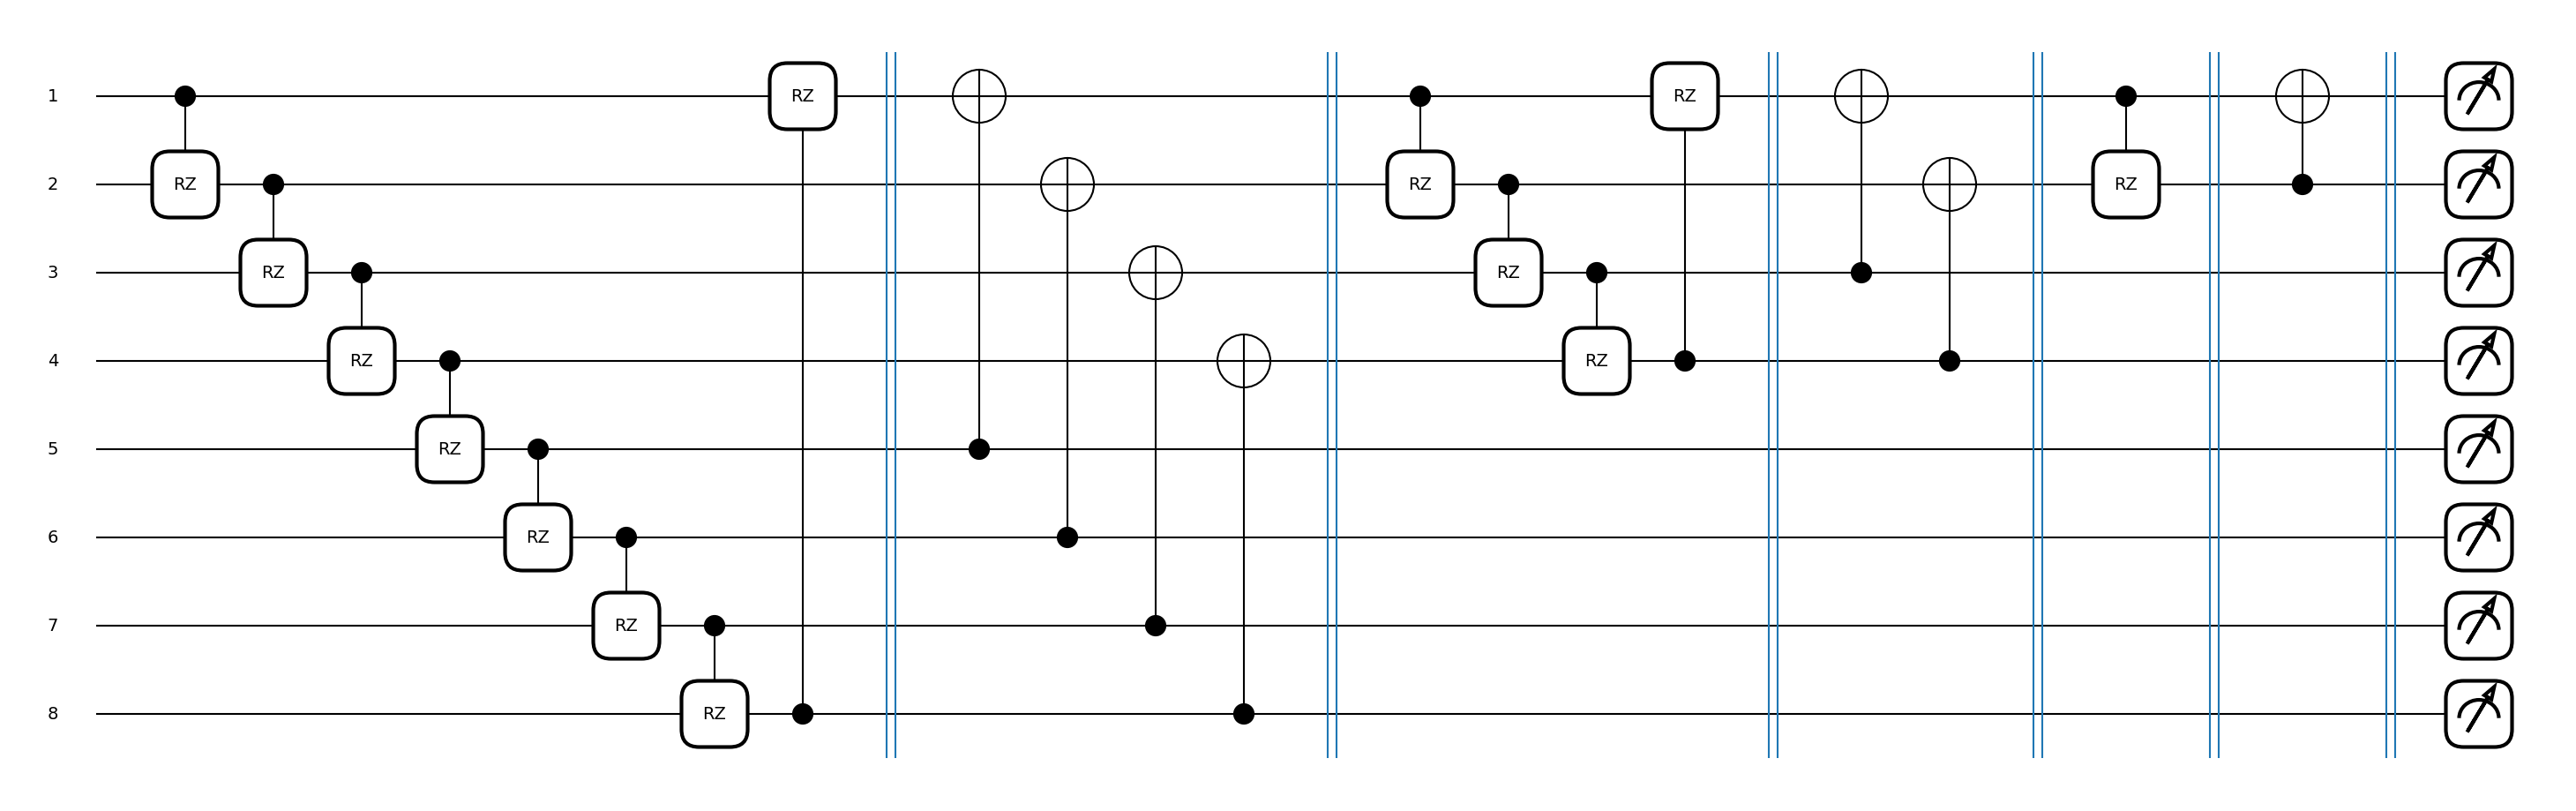

In [52]:
hierq = Qinit(8) + (Qcycle(mapping=u2) + Qmask("right", mapping=v2))*3
circuit = get_circuit(hierq)
draw_circuit(circuit)

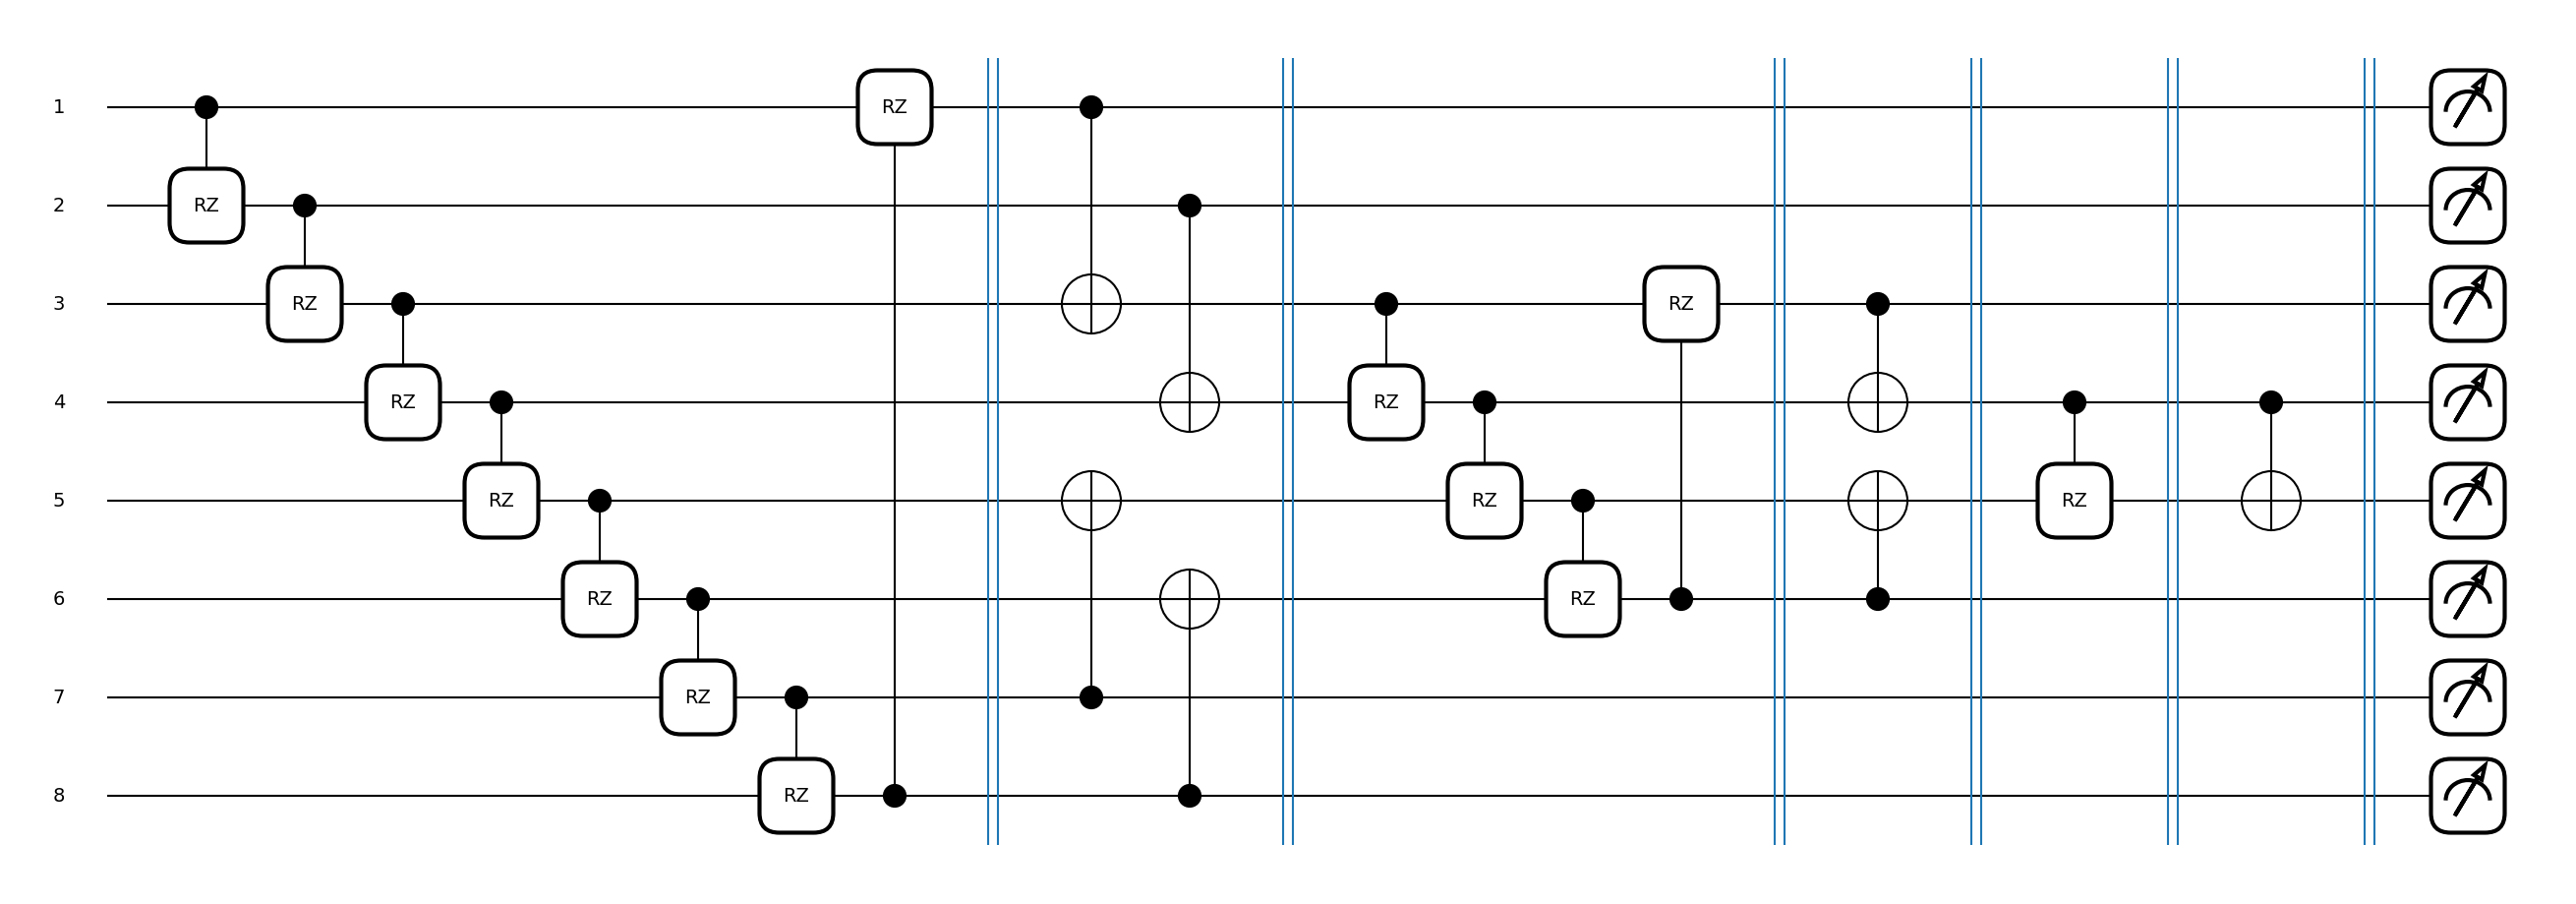

In [53]:
hierq = Qinit(8) + (Qcycle(mapping=u2) + Qmask("outside", mapping=v2))*3
circuit = get_circuit(hierq)
draw_circuit(circuit)

## MERA from Grant et al.
The Multi-scale Entanglement Renormalization Ansatz (MERA) architecture from [Hierarchical quantum classifiers, Grant et al.](https://www.nature.com/articles/s41534-018-0116-9). We generate a N-qubit MERA circuit, change N to 4,8,16,32 to see how simple scaling the same circuit design is. Note that v4 is a 4-qubit unitary, which illustrates how primitves can handle N-qubit unitaries.

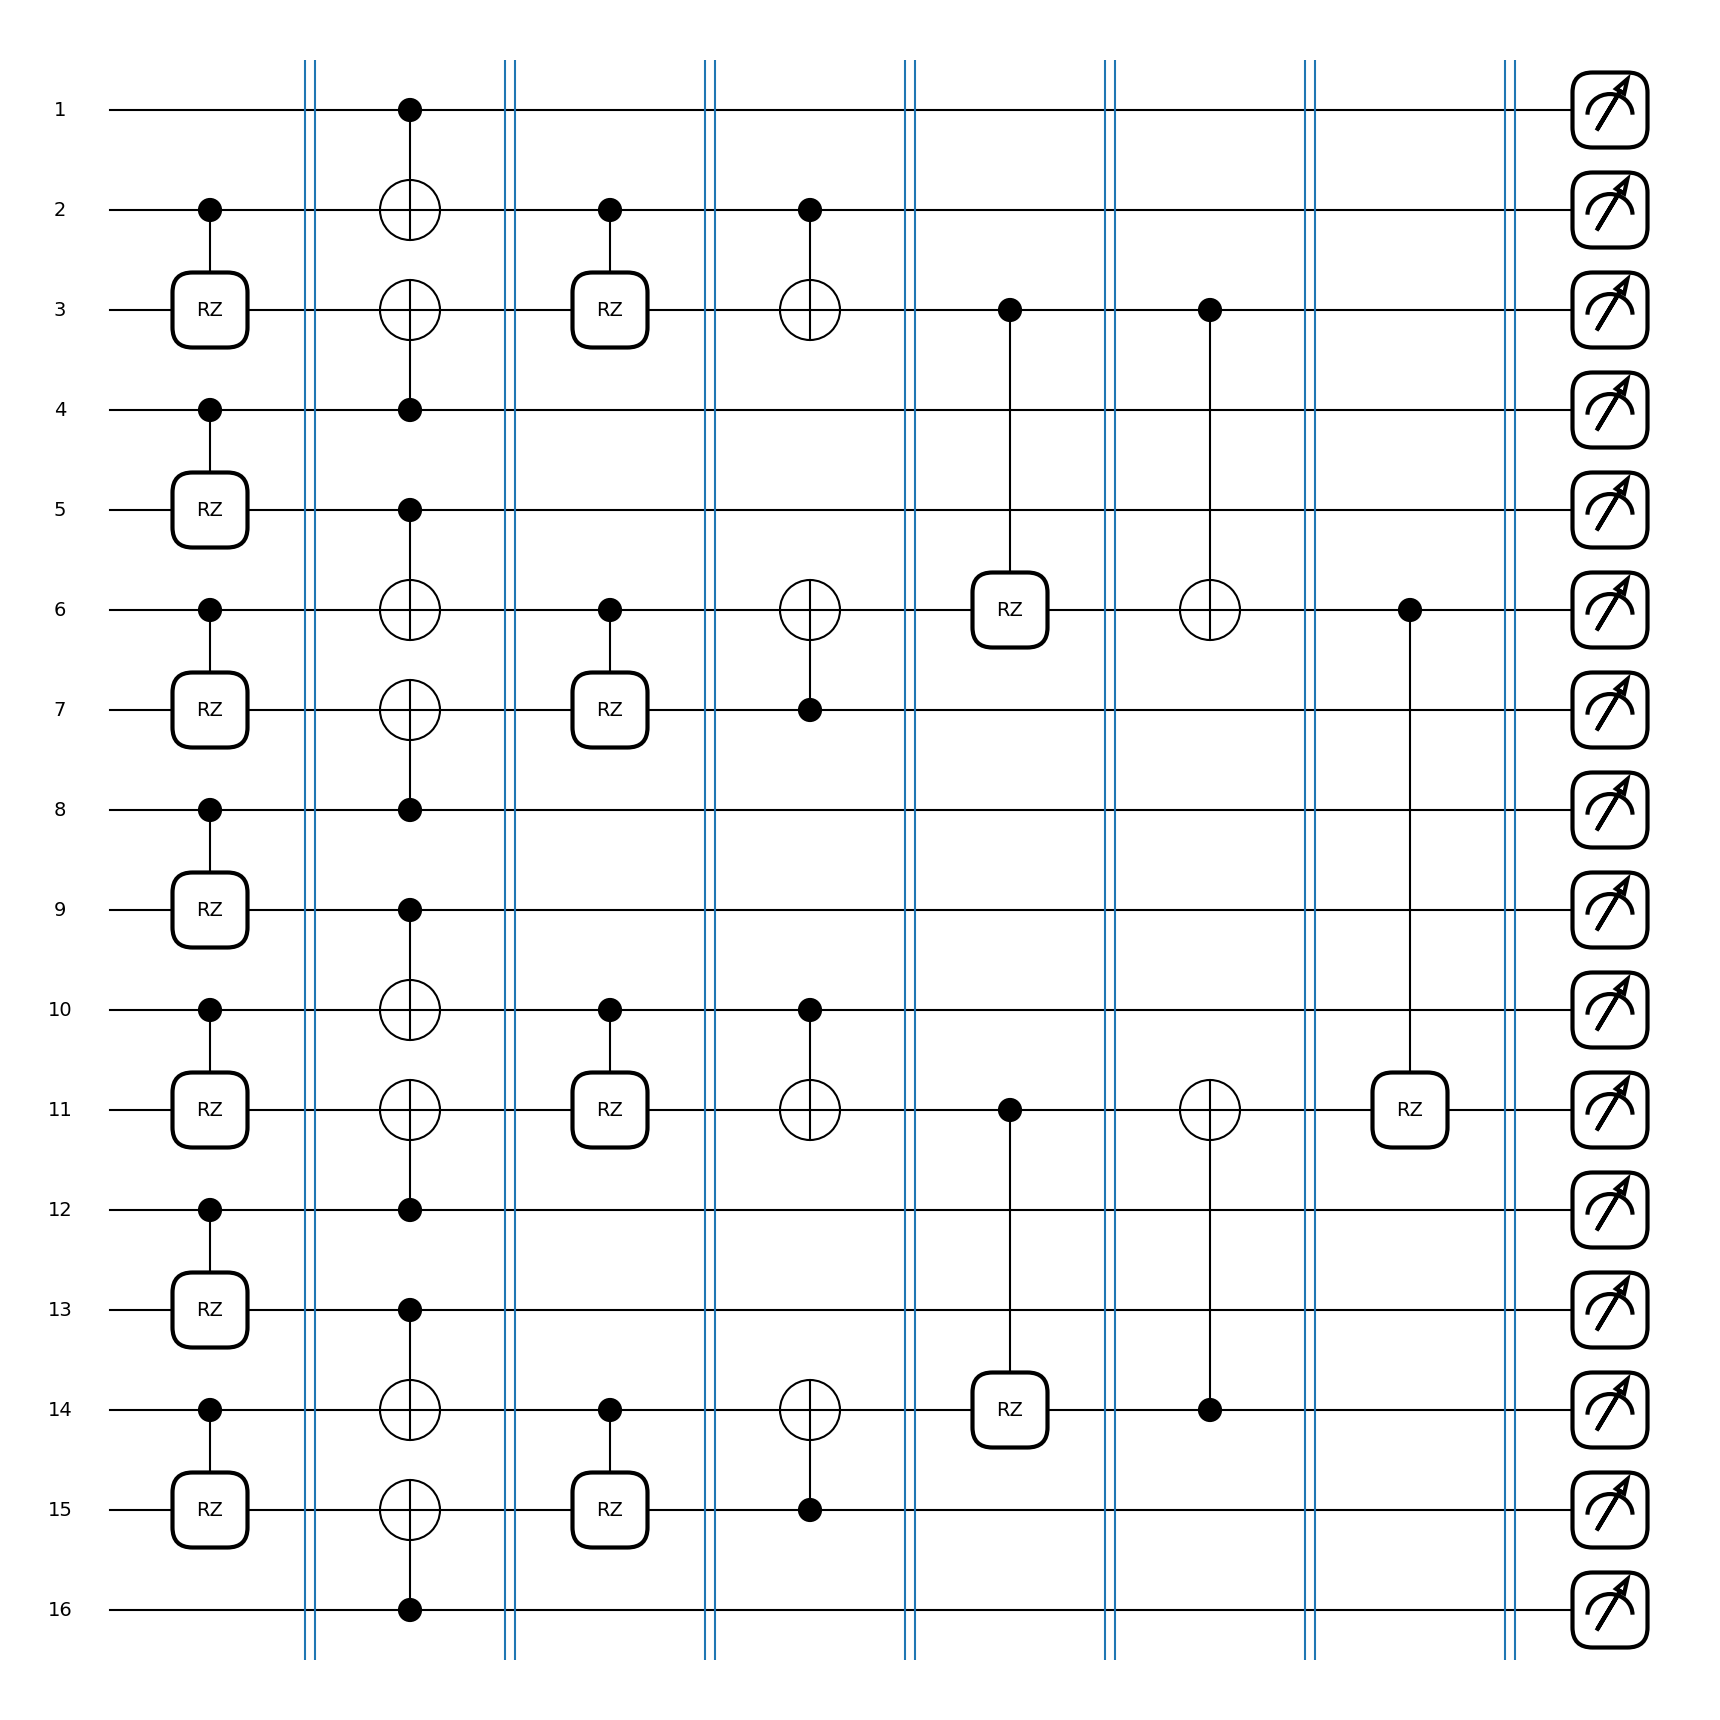

In [54]:
N=16
m1_1 = Qcycle(1,2,1, mapping=u2, boundary="open")
m2_1 = Qmask("1001", stride=1, step=4, mapping=v4, boundary="open")
m3_1 = Qcycle(1,2,0, mapping=u2, boundary="open")
m1_2 = m2_1 + m3_1
hierq = Qinit(N) + m1_1 + m1_2 * (int(np.log2(N))-1)
# Draw the circuit
circuit = get_circuit(hierq)
draw_circuit(circuit)

## Sub motif as a mapping for a motif

### A cycle of cycles

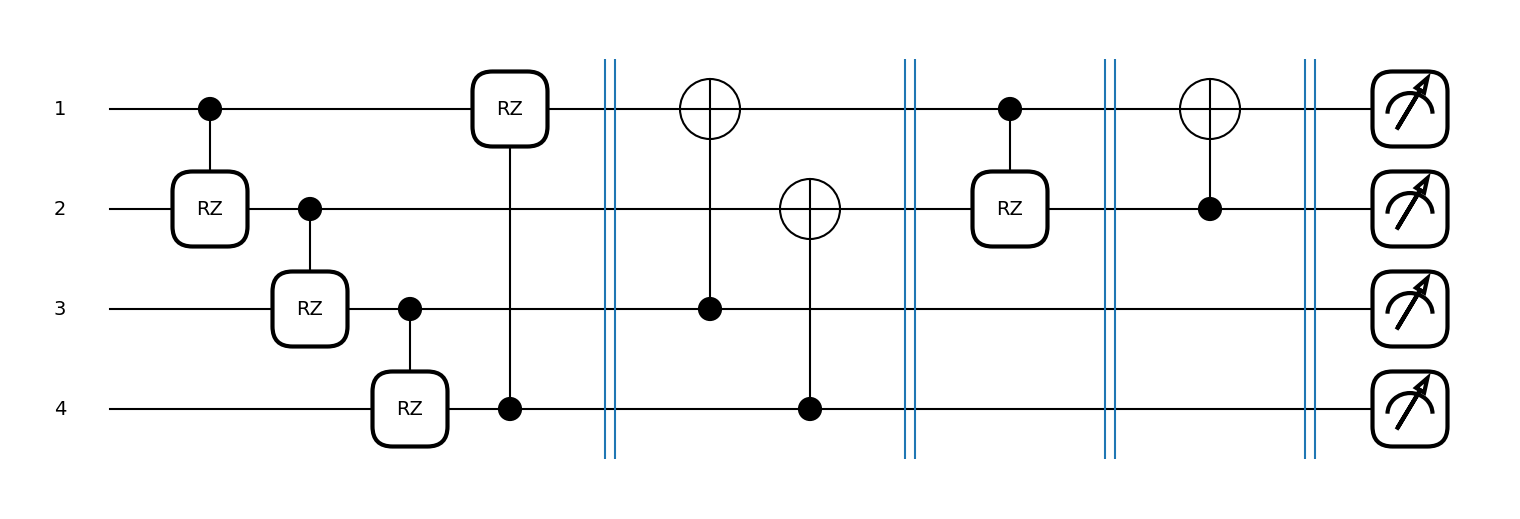

In [55]:
m1 = Qinit(4) + (Qcycle(mapping=u2) + Qmask("right", mapping=v2)) * 2
circuit = get_circuit(m1)
draw_circuit(circuit)

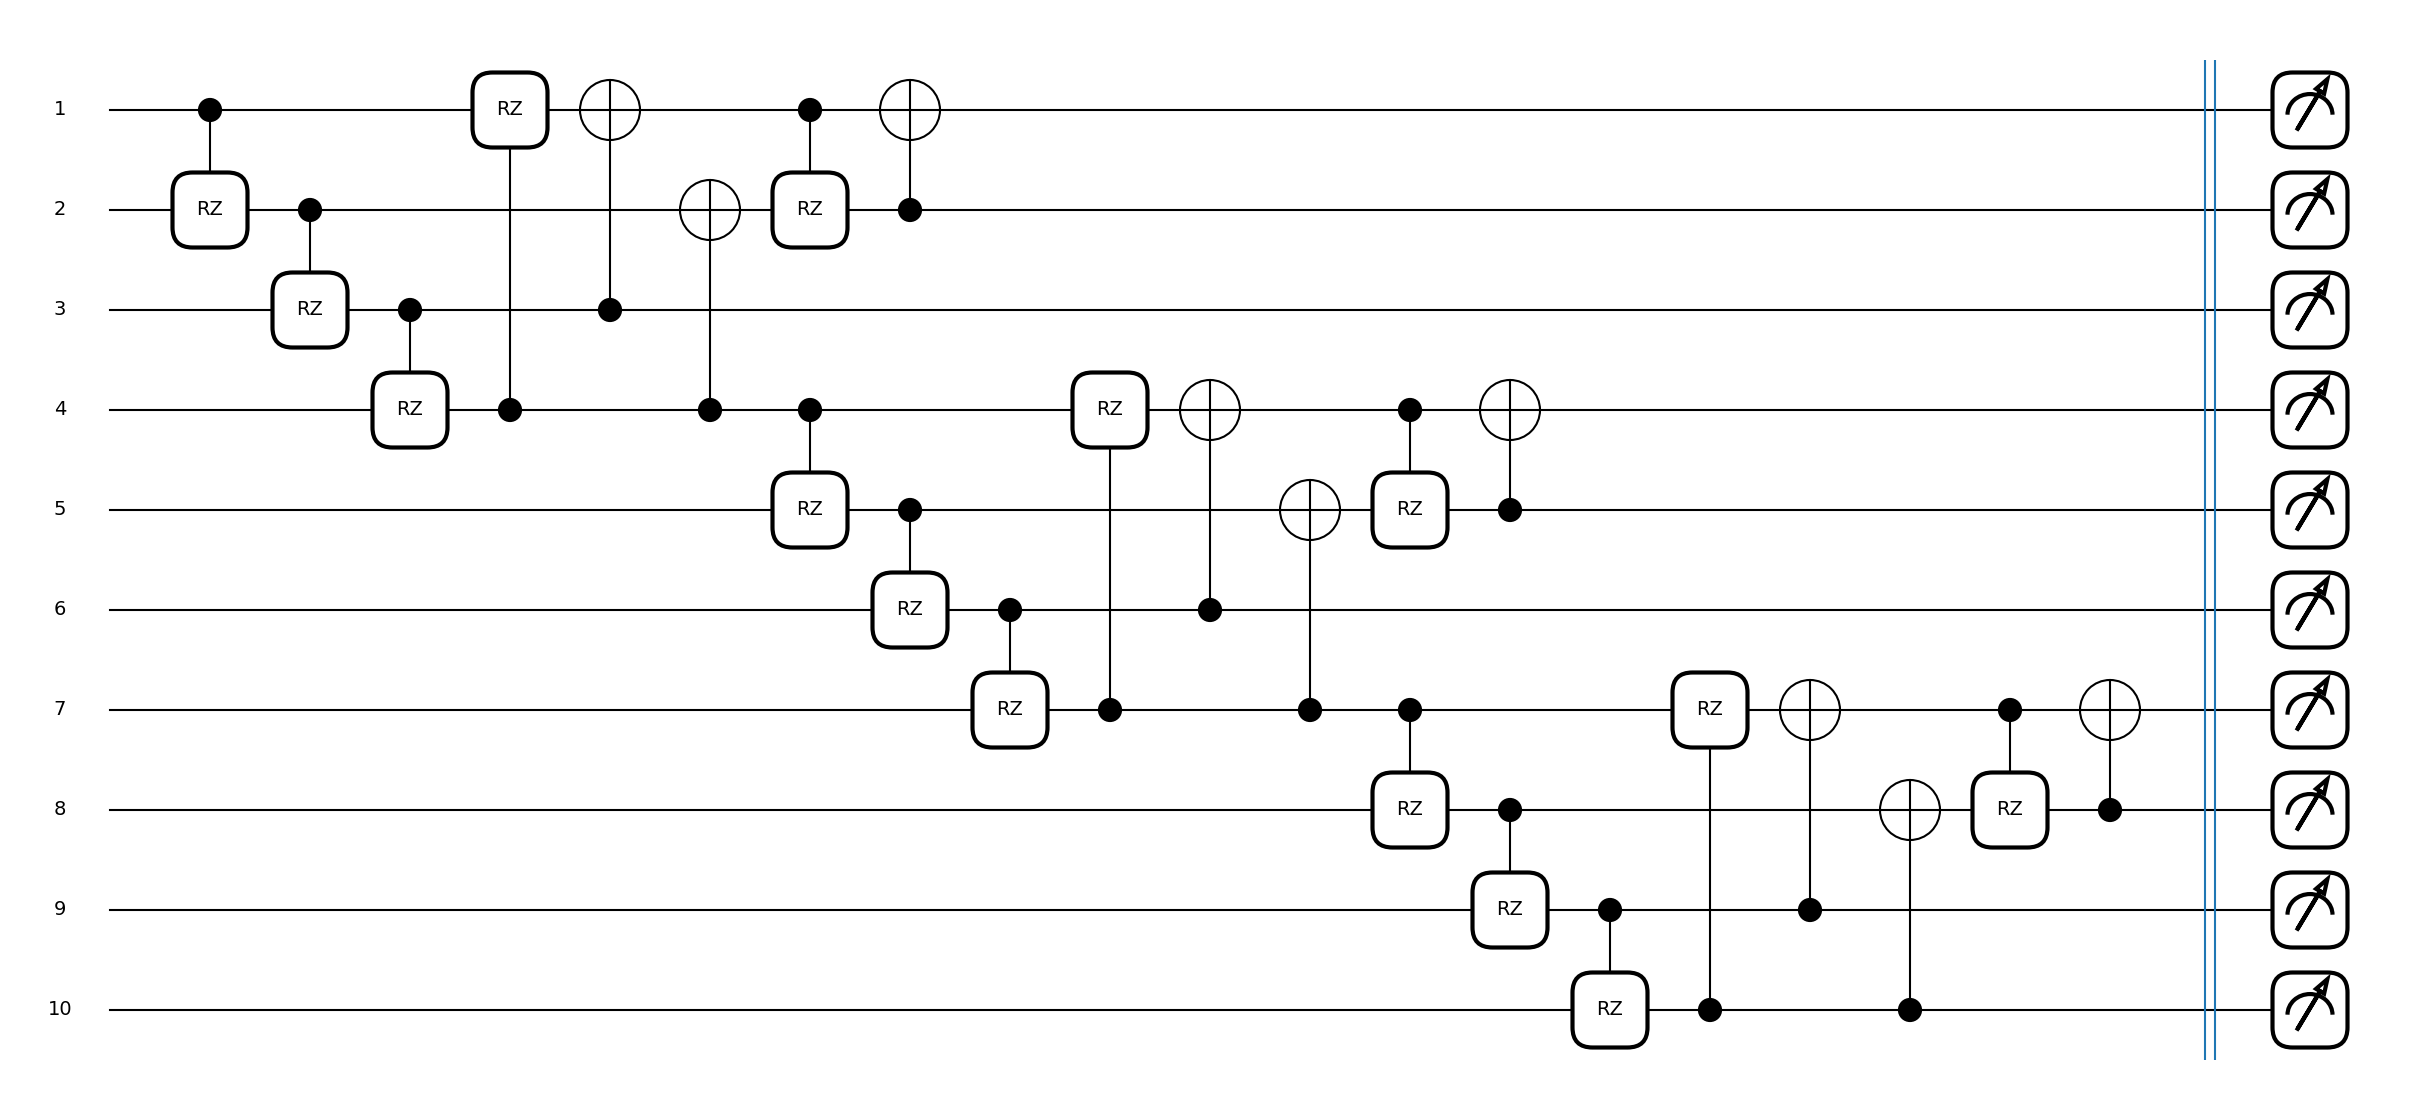

In [56]:
hierq = Qinit(10) + Qcycle(1, 3, mapping=m1, boundary="open")
circuit = get_circuit(hierq)
draw_circuit(circuit)

### A cycle of cycles of permutations

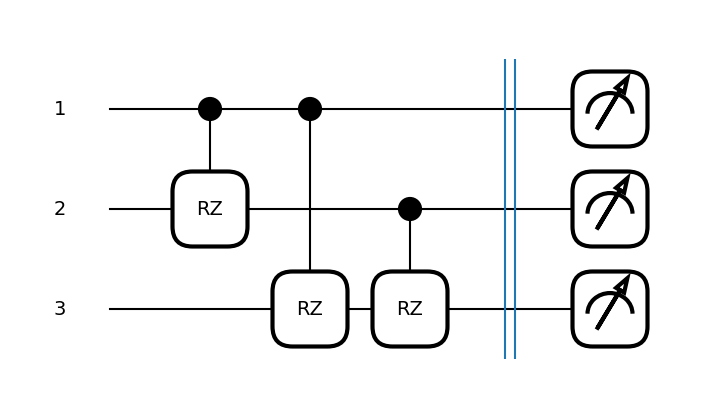

In [57]:
subsub = Qinit(3) + Qpermute(mapping=u2, share_weights=False, combinations=True)
circuit = get_circuit(subsub)
draw_circuit(circuit)

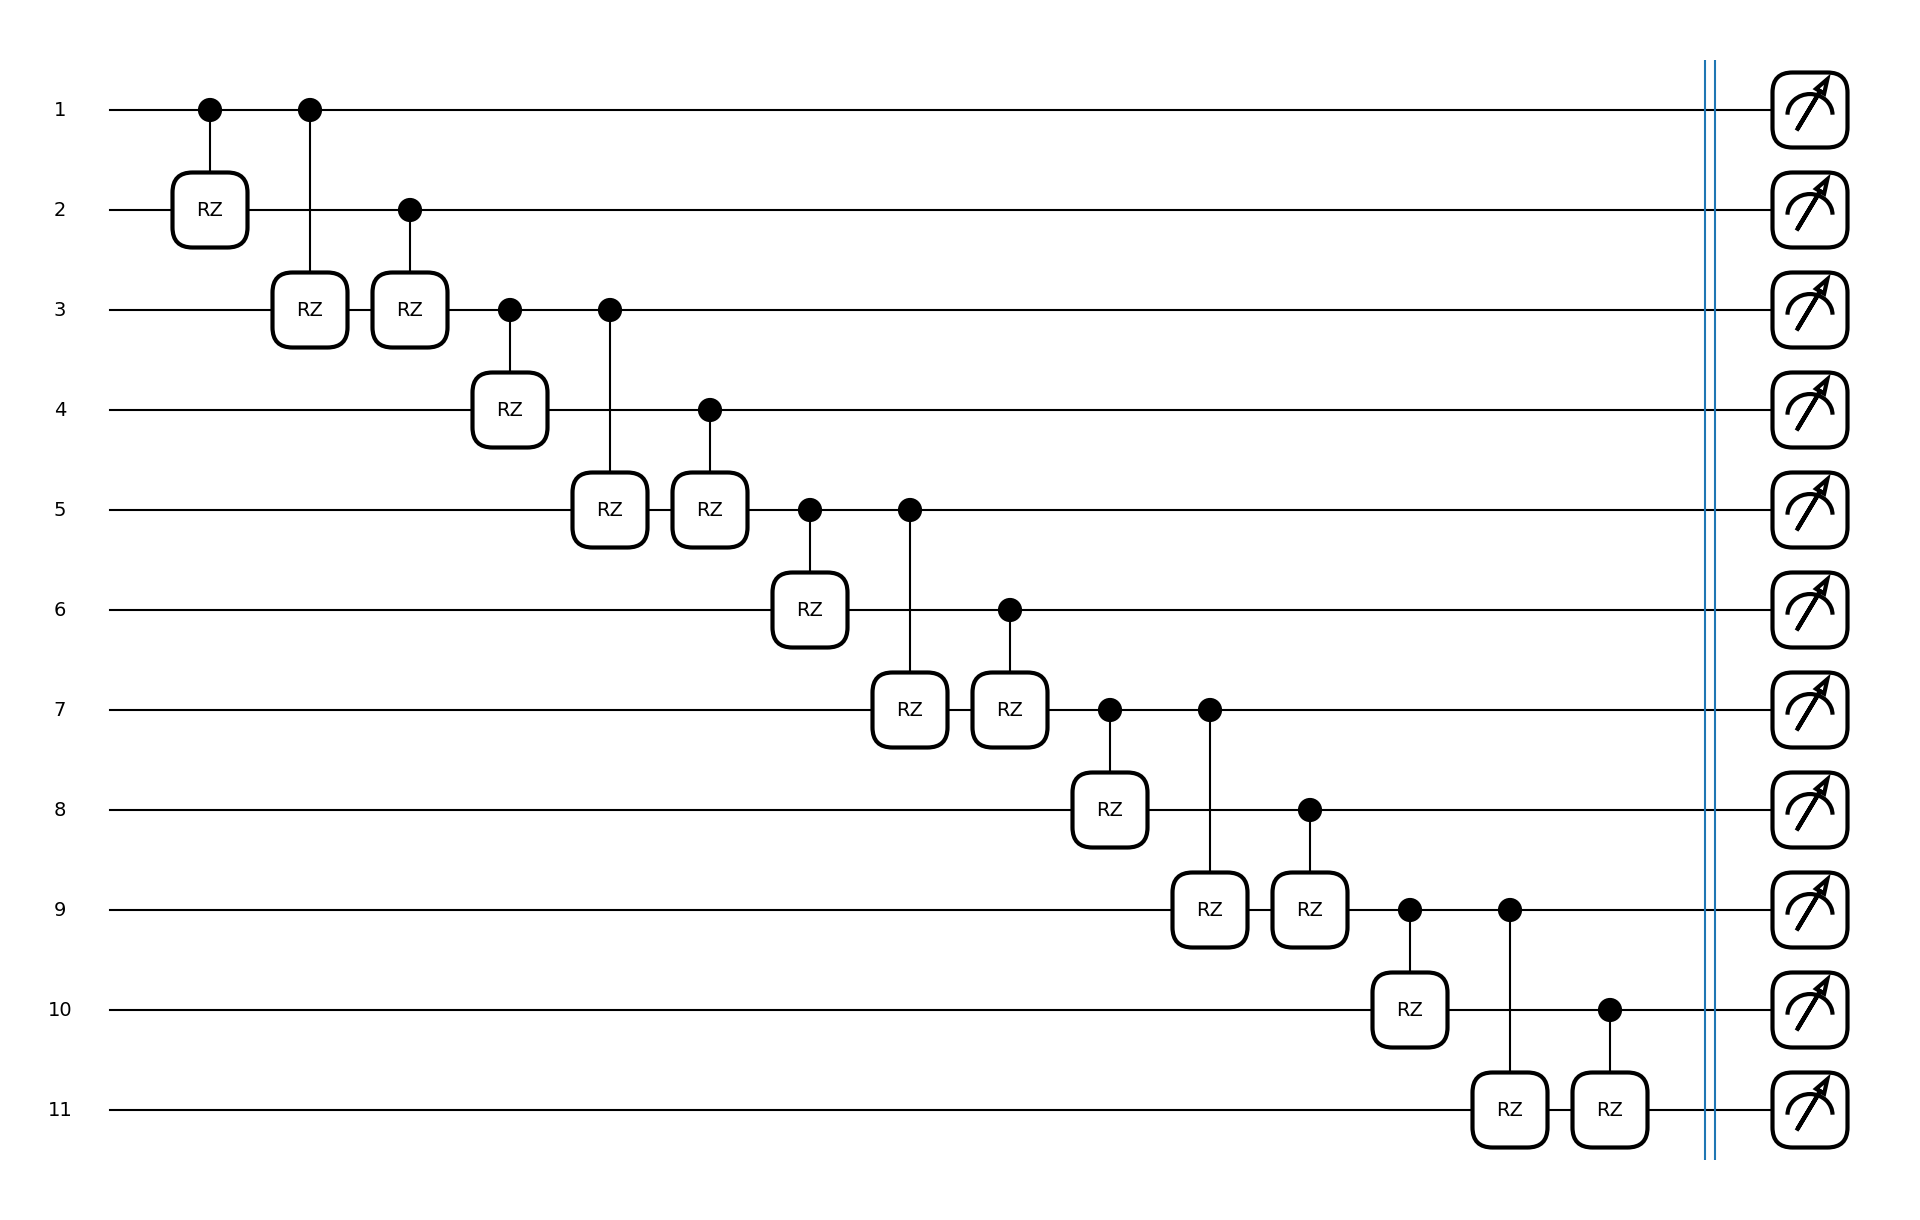

In [58]:
sub = Qinit(11) + Qcycle(
    1, 2, 0, mapping=subsub, share_weights=True, boundary="open"
)
circuit = get_circuit(sub)
draw_circuit(circuit)

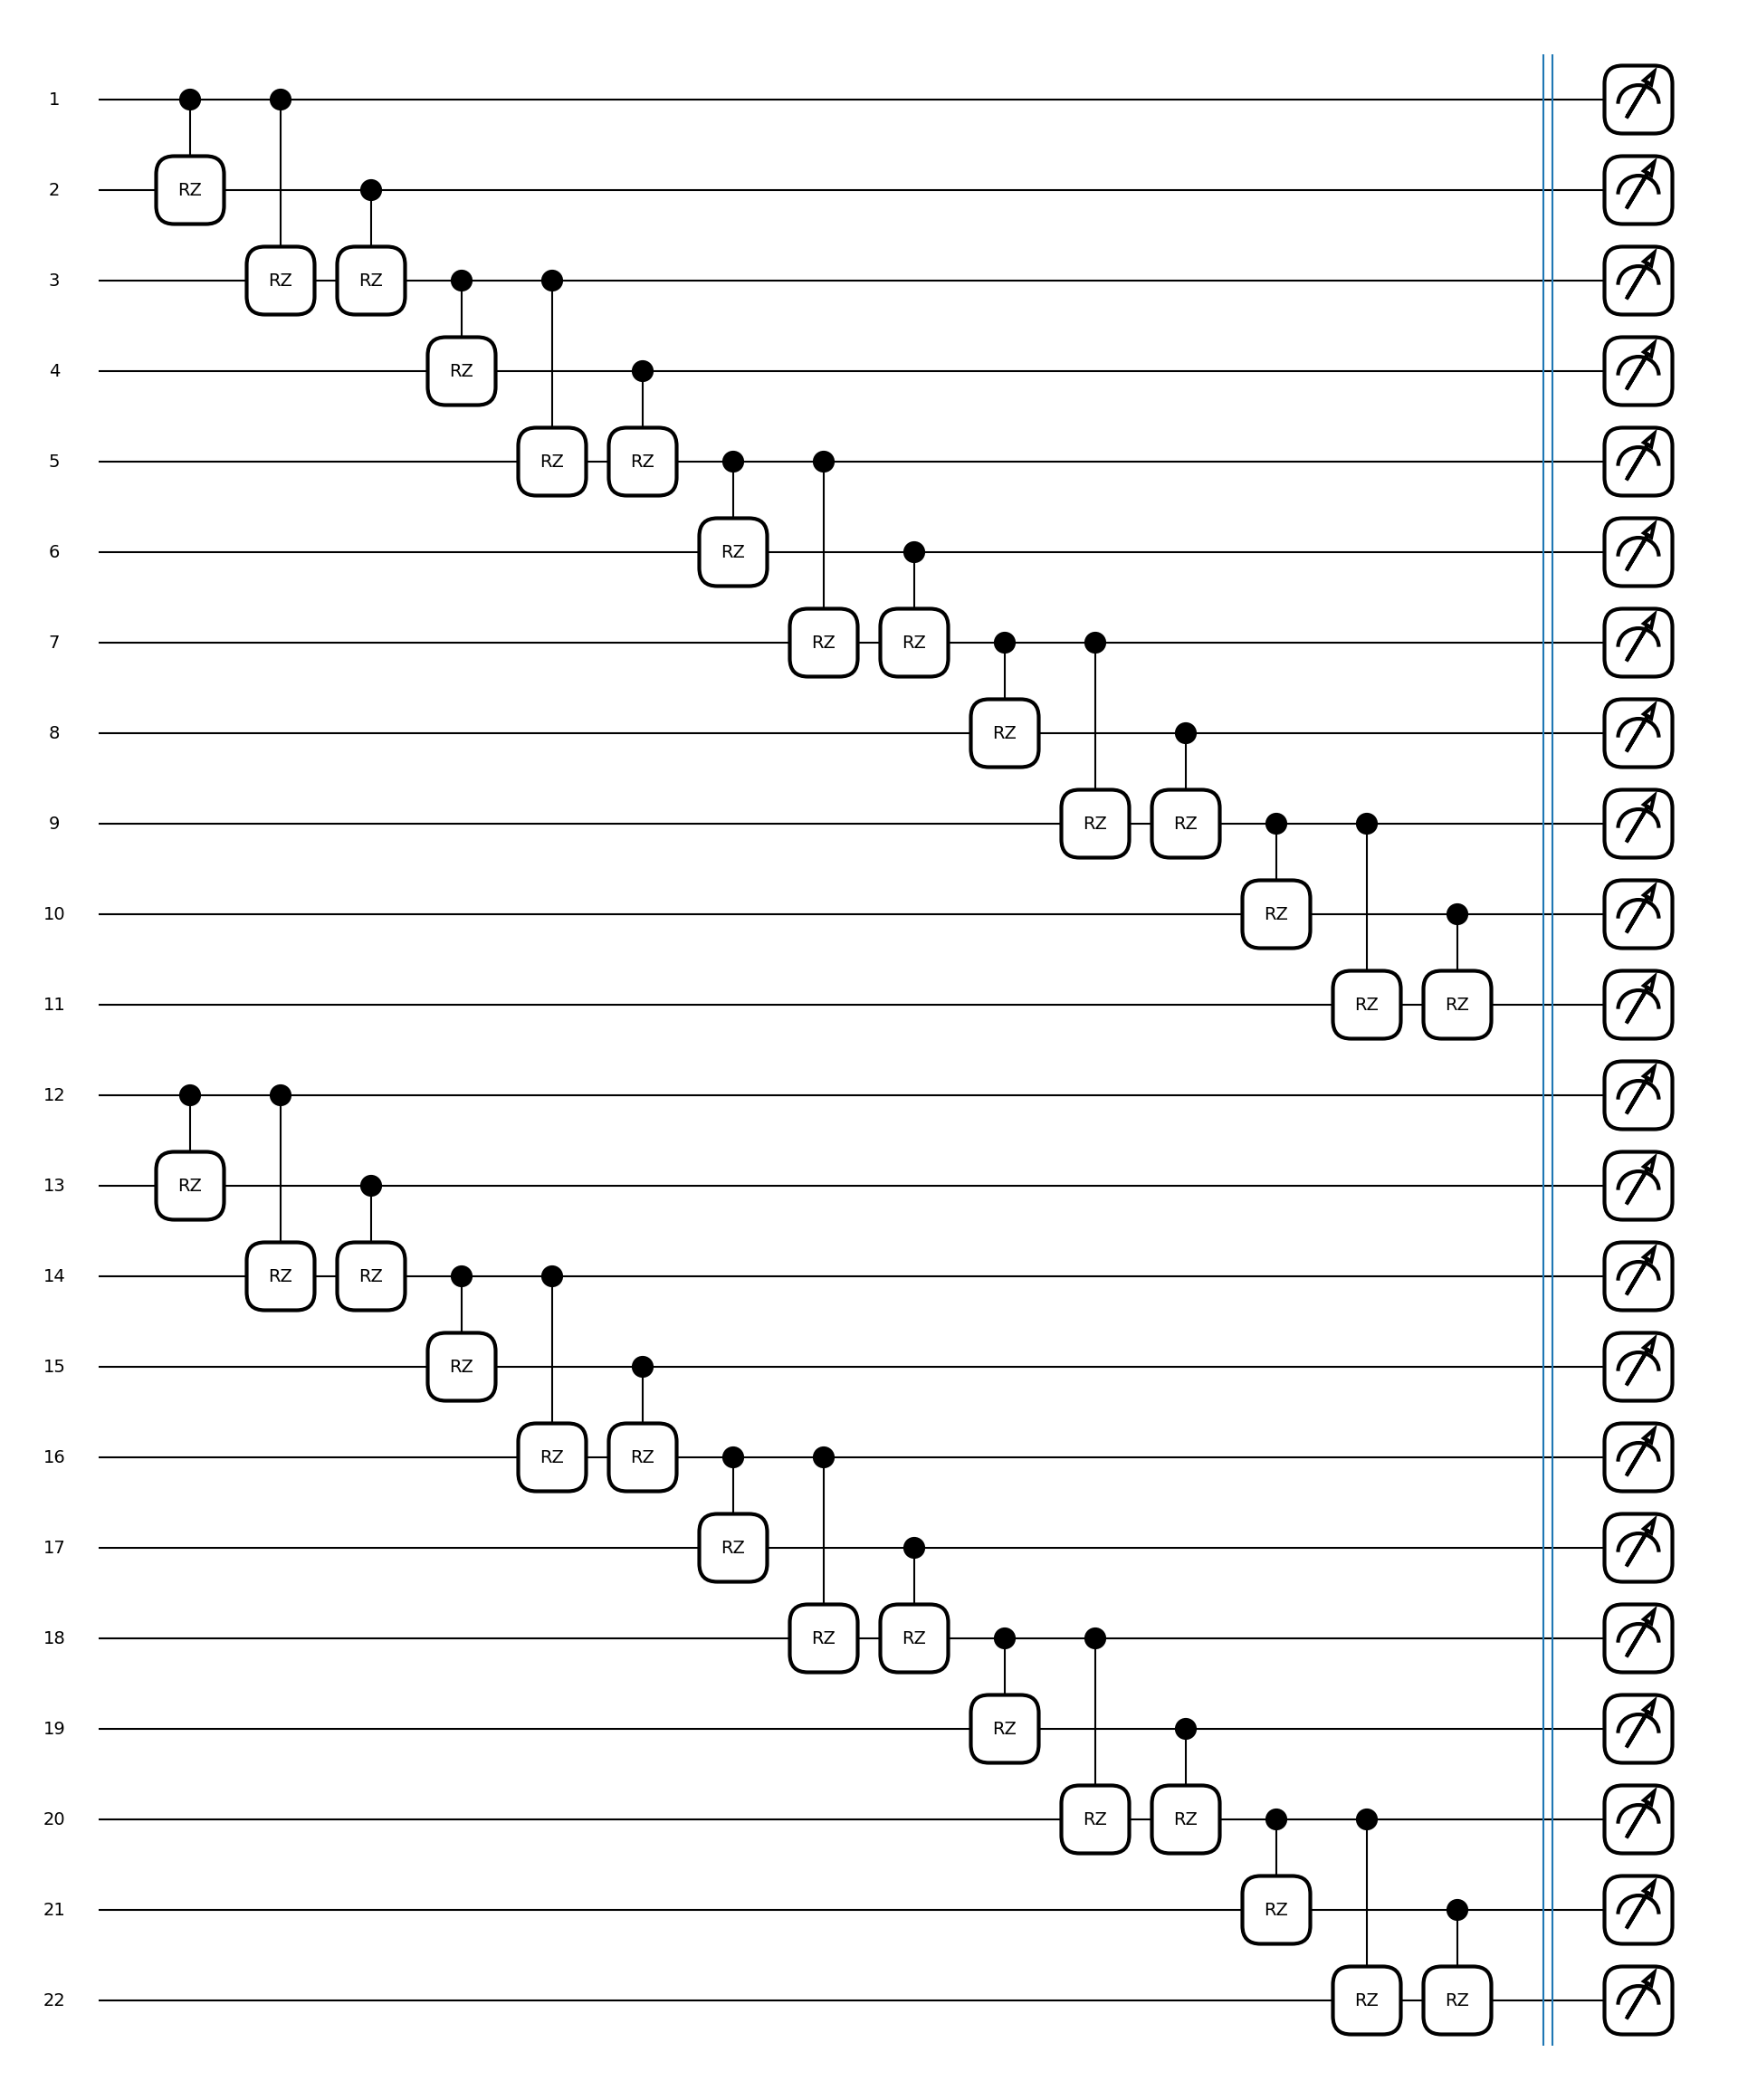

In [59]:
hierq = Qinit(22) + Qcycle(1, 11, 0, mapping=sub, share_weights=False, boundary="open")
circuit = get_circuit(hierq)
draw_circuit(circuit)

## Parameter management


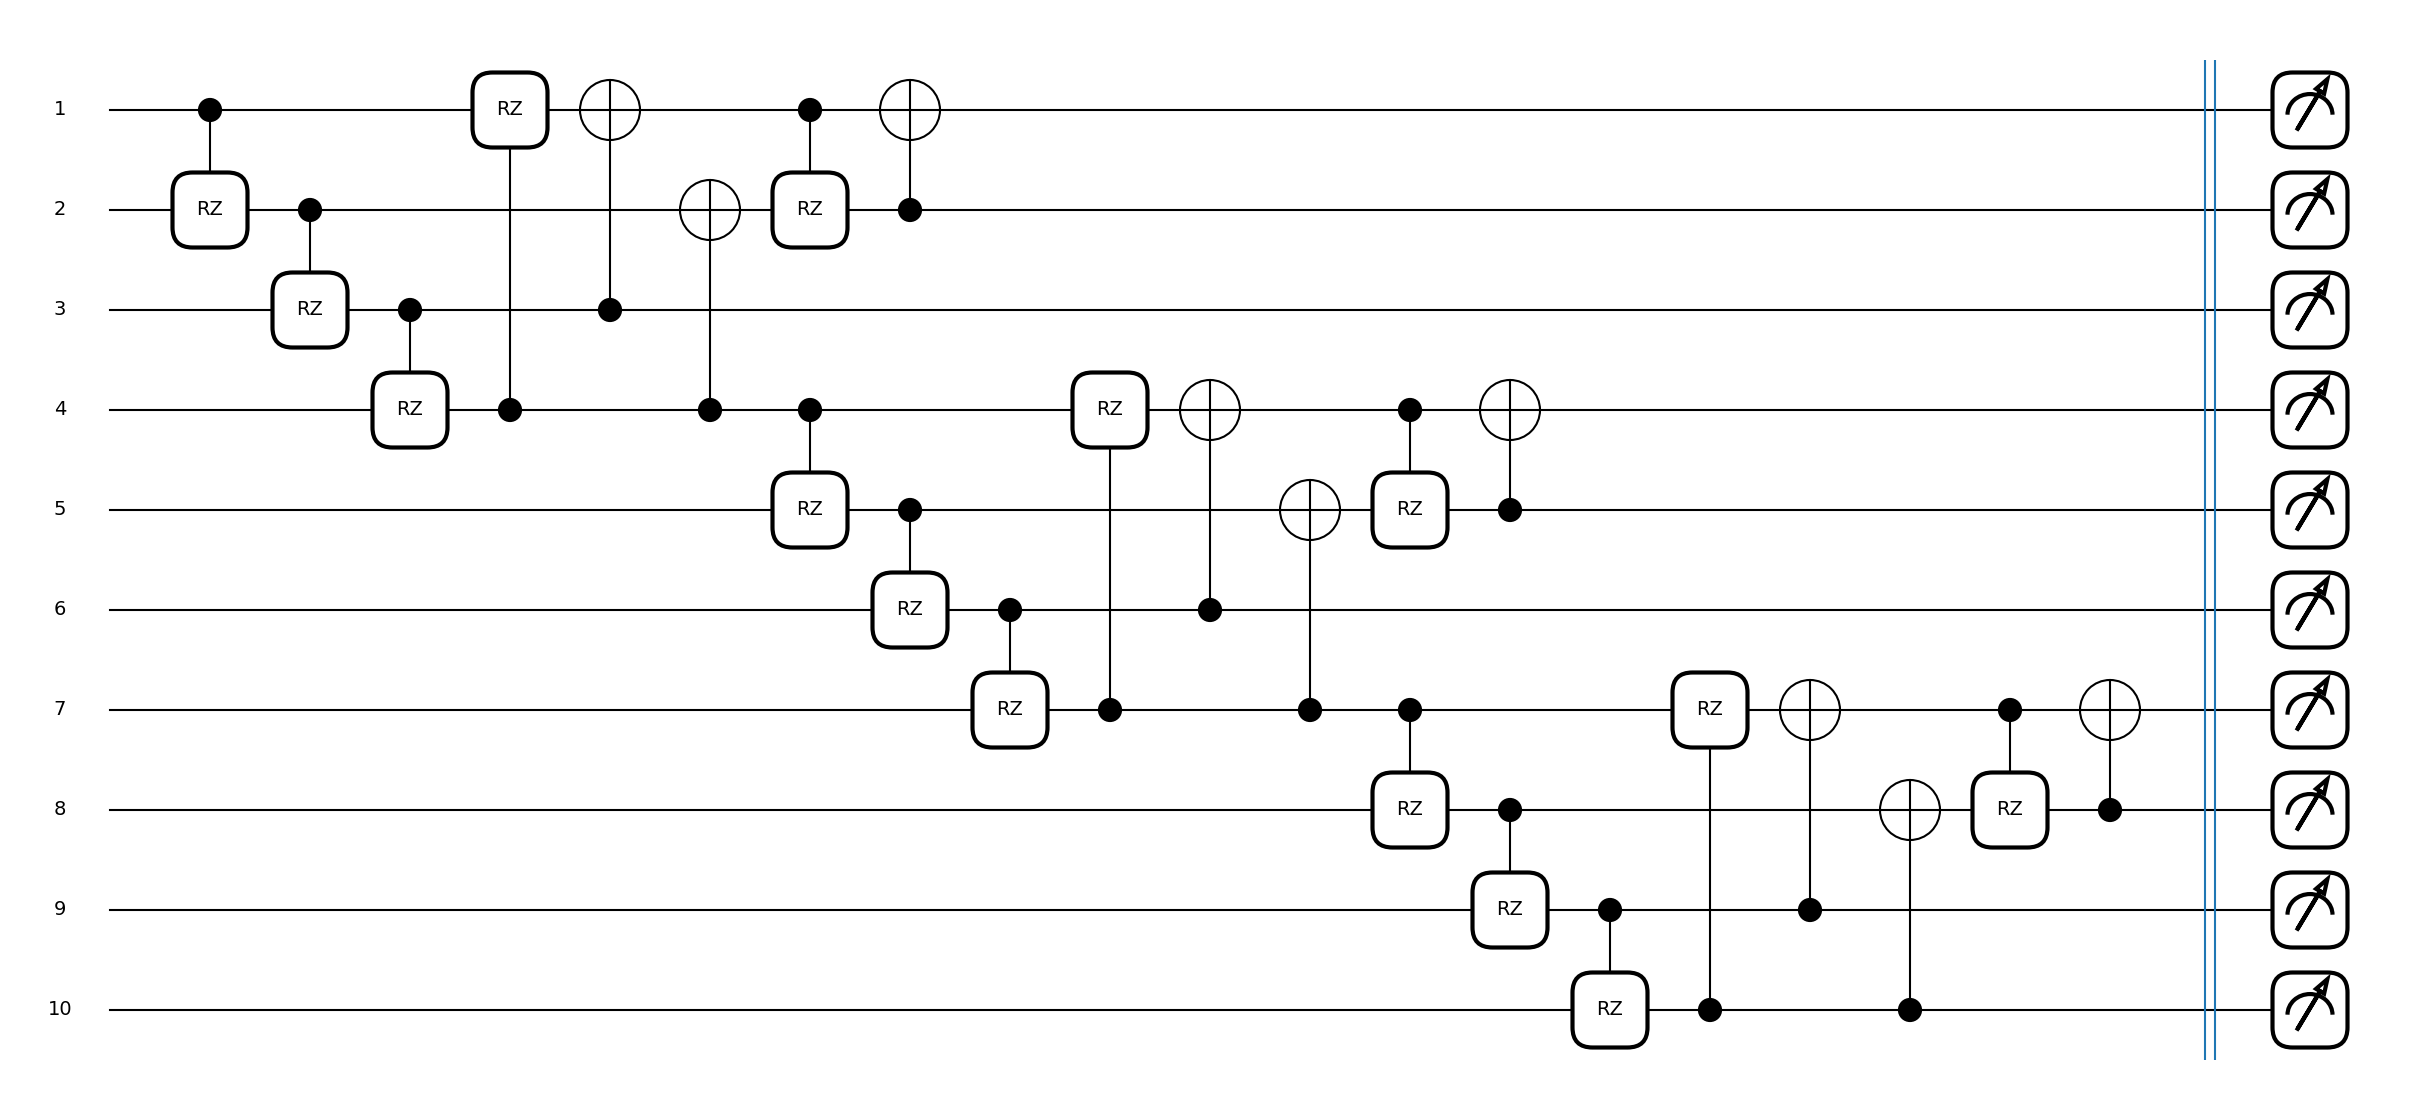

In [60]:
m1 = Qinit(4) + (Qcycle(mapping=u2, share_weights=False) + Qmask("right", mapping=v2)) * 2
hierq = Qinit(10) + Qcycle(1, 3, mapping=m1, boundary="open", share_weights=False)
circuit = get_circuit(hierq)
draw_circuit(circuit)

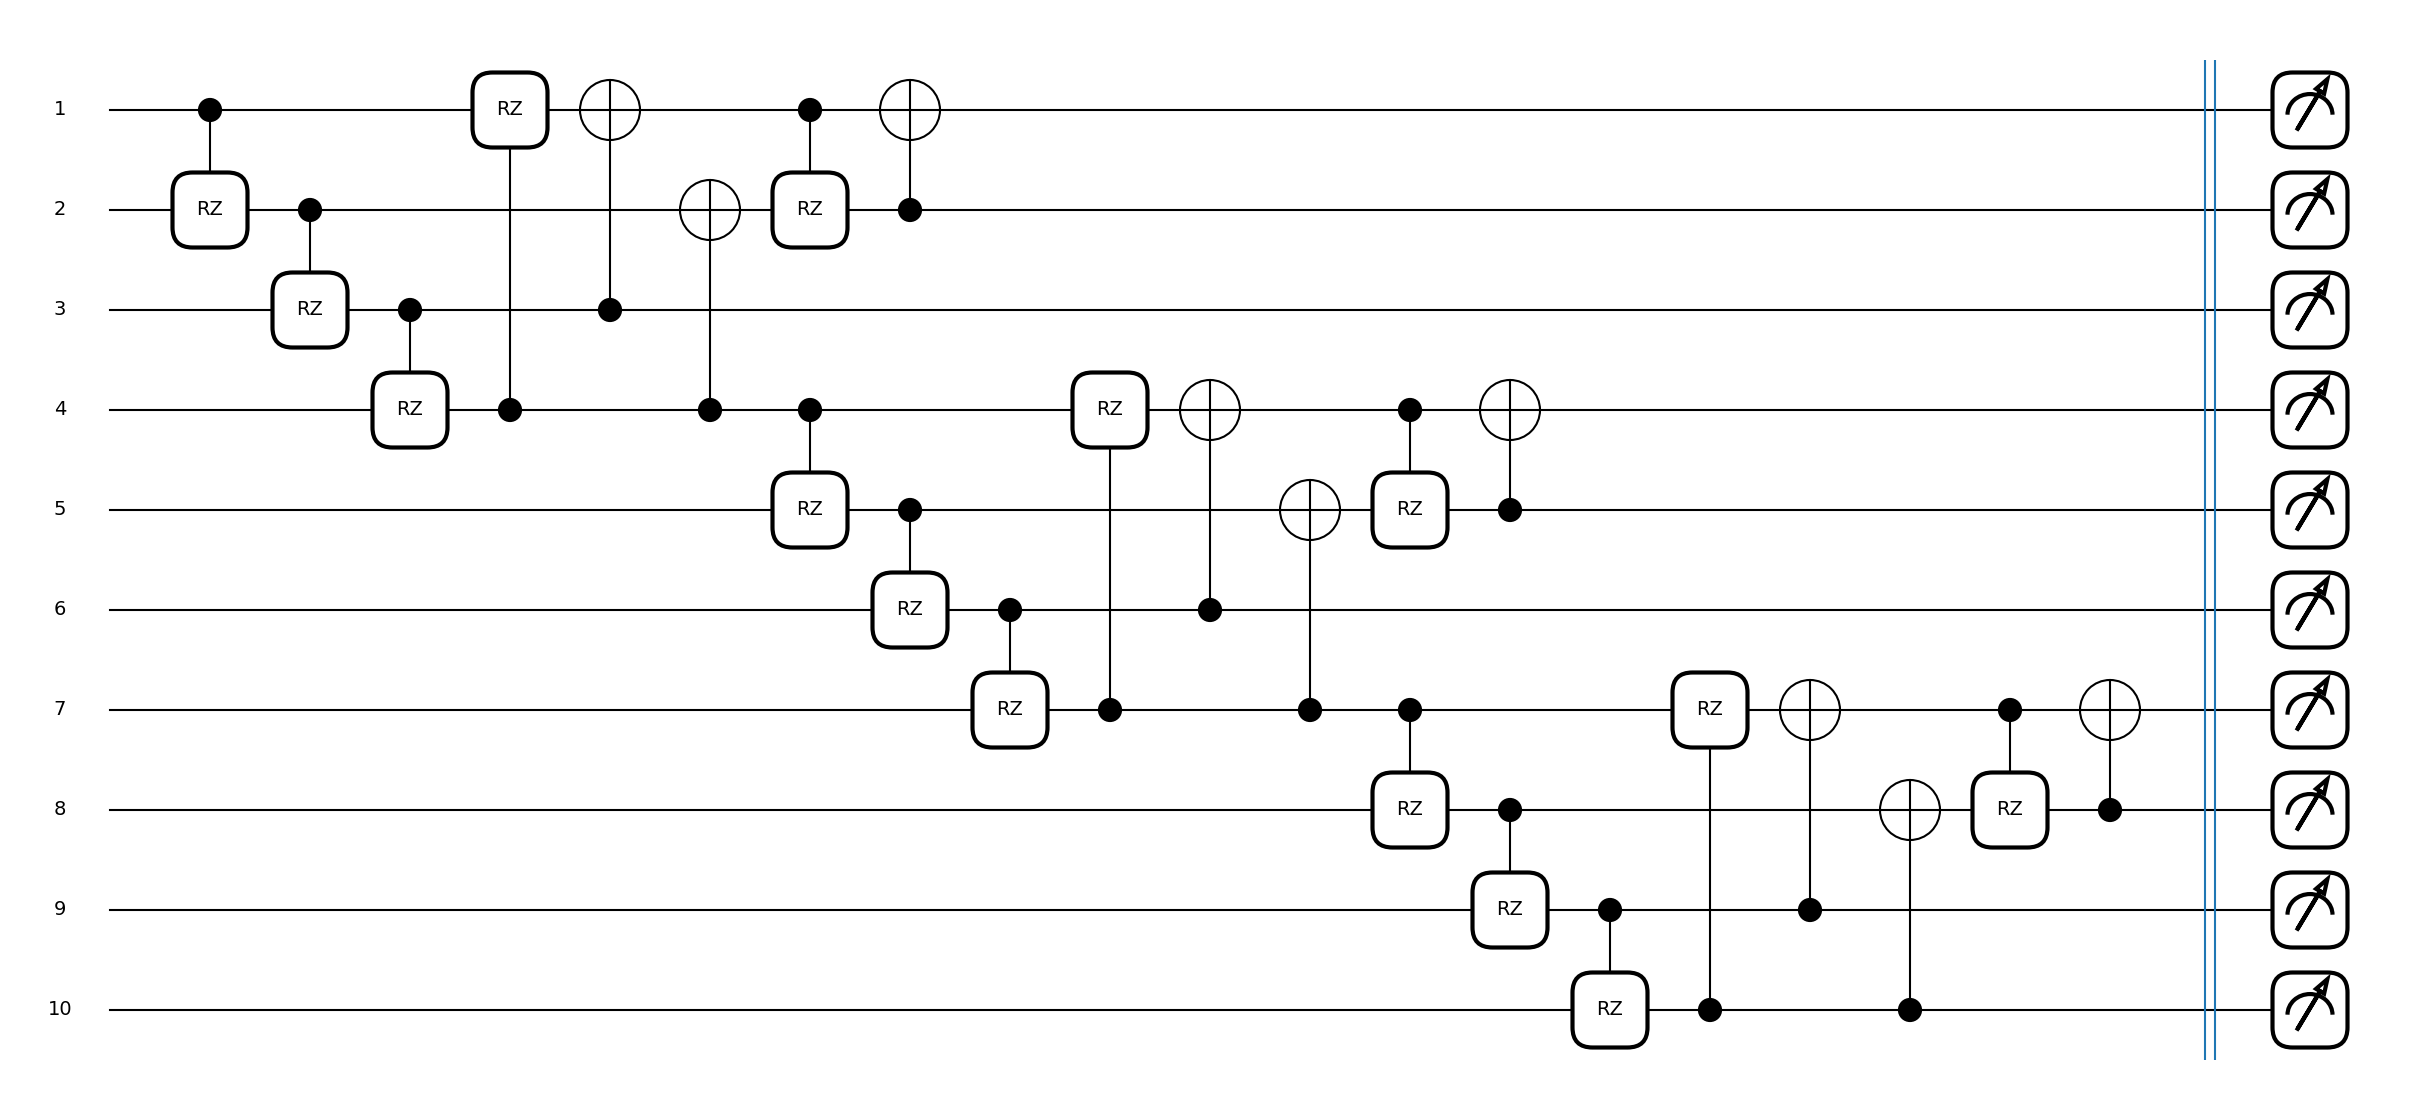

In [61]:
m1 = Qinit(4) + (Qcycle(mapping=u2, share_weights=False) + Qmask("right", mapping=v2)) * 2
hierq = Qinit(10) + Qcycle(1, 3, mapping=m1, boundary="open", share_weights=True)
circuit = get_circuit(hierq)
draw_circuit(circuit)

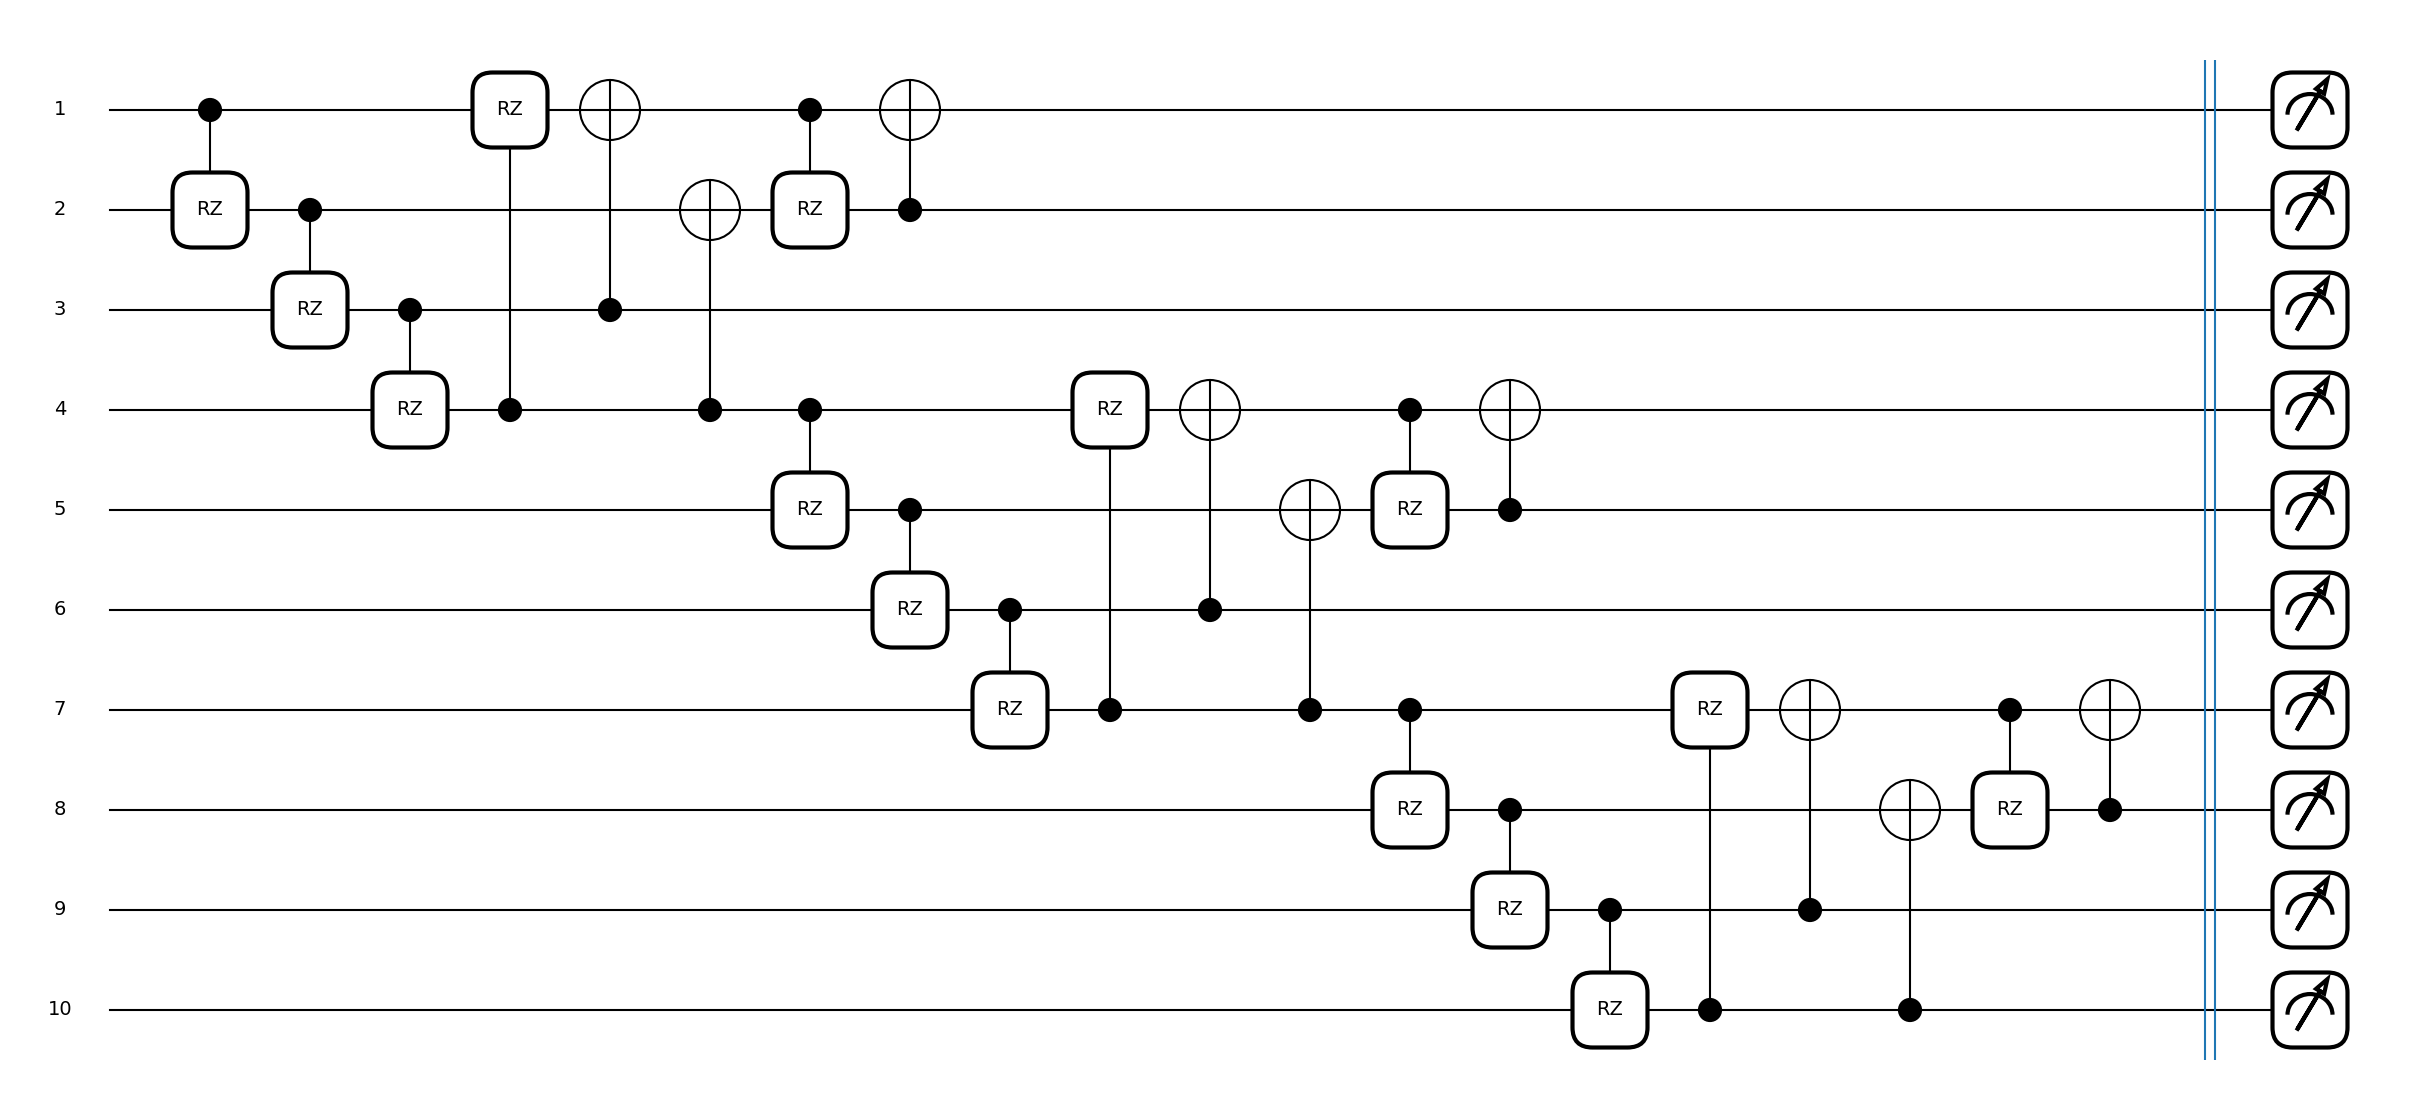

In [62]:
m1 = Qinit(4) + (Qcycle(mapping=u2, share_weights=True) + Qmask("right", mapping=v2)) * 2
hierq = Qinit(10) + Qcycle(1, 3, mapping=m1, boundary="open", share_weights=False)
circuit = get_circuit(hierq)
draw_circuit(circuit)

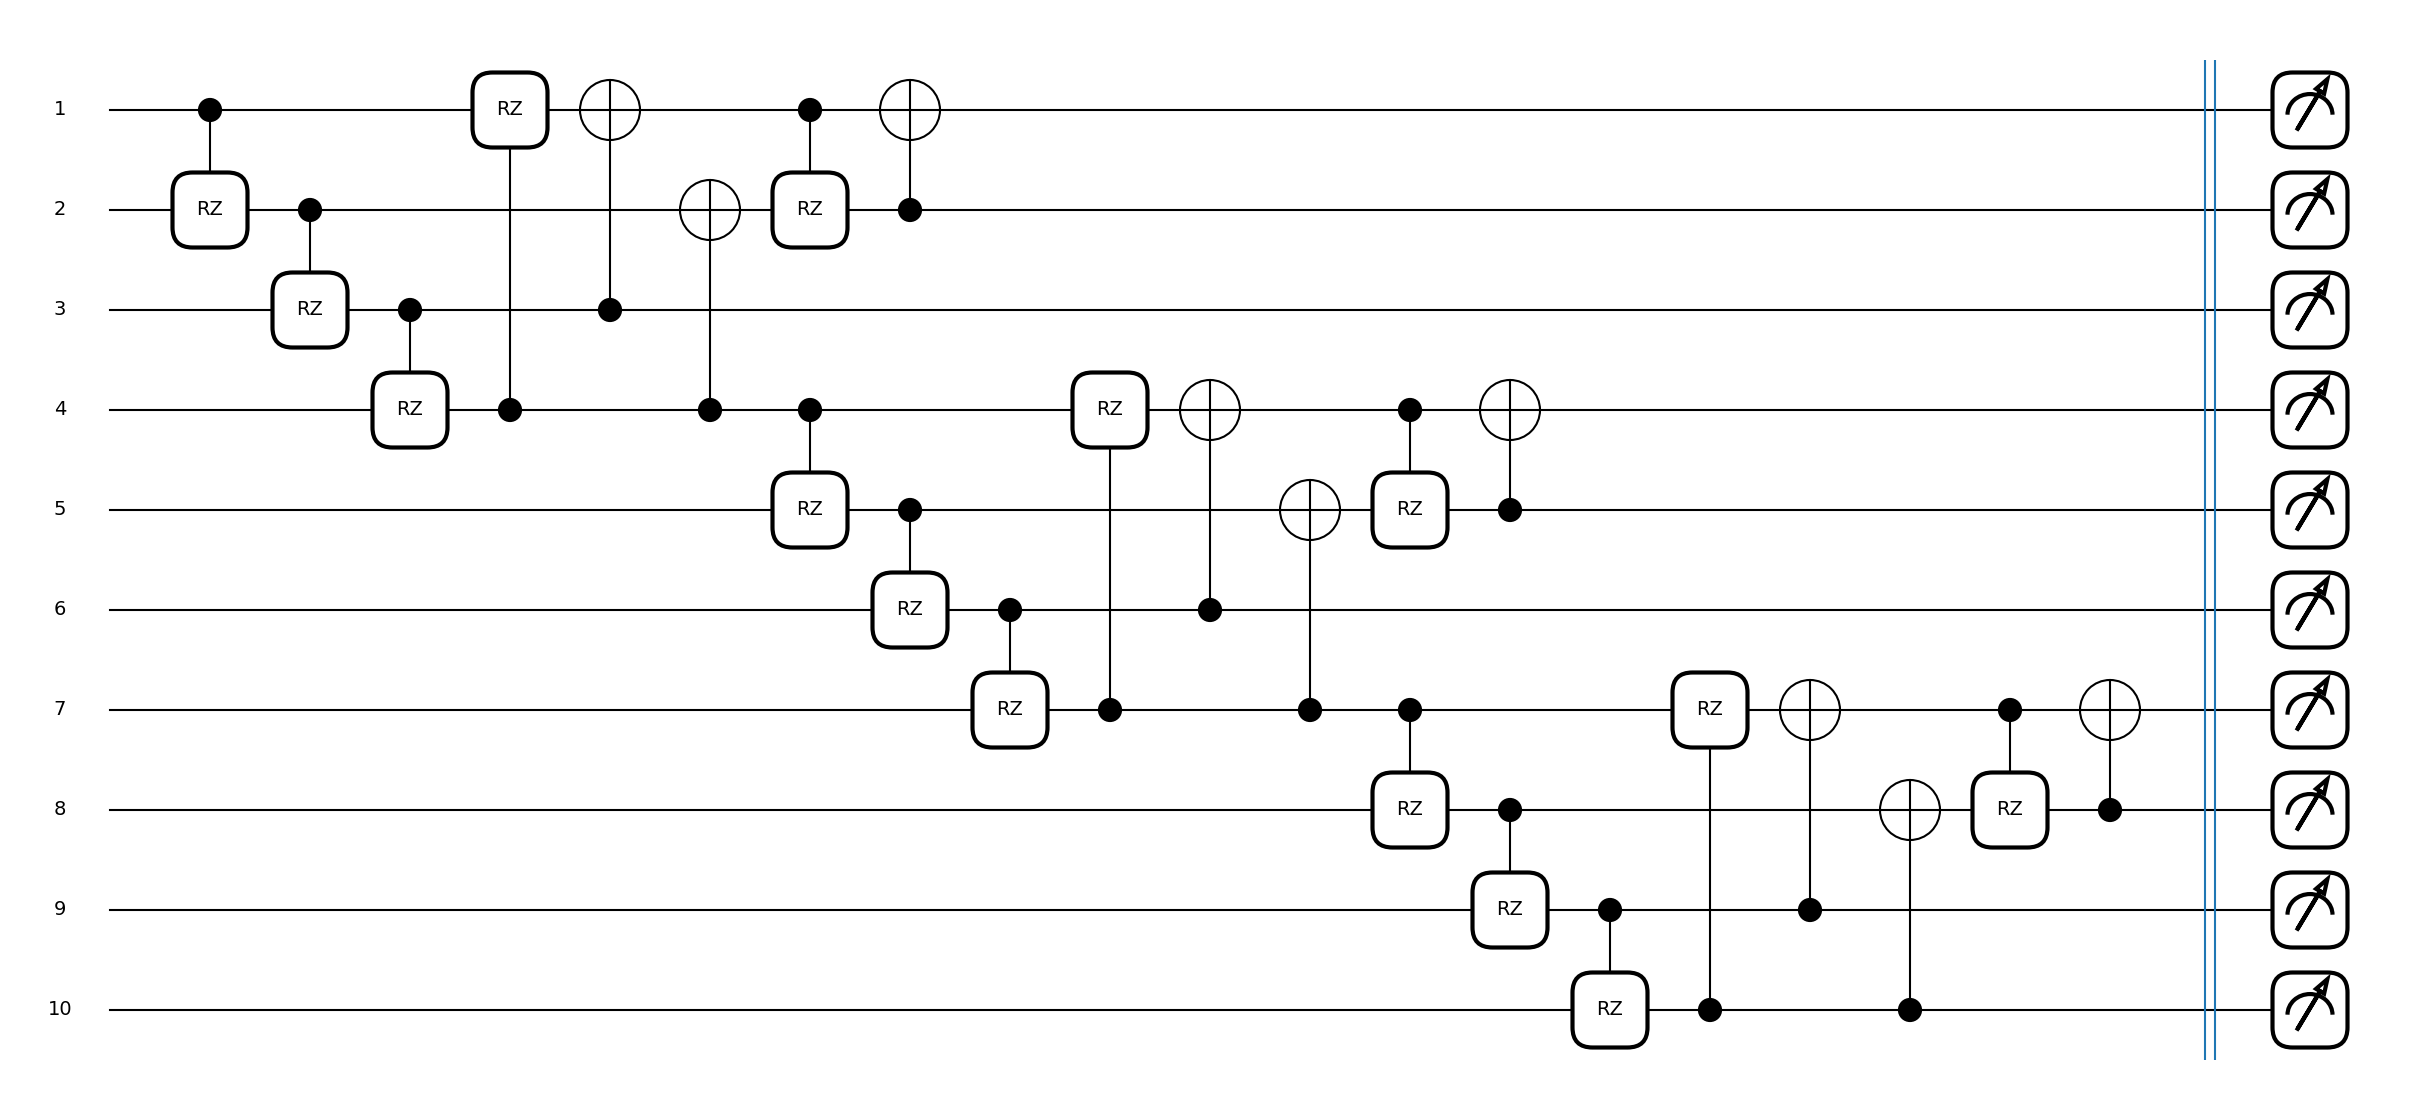

In [63]:
m1 = Qinit(4) + (Qcycle(mapping=u2, share_weights=True) + Qmask("right", mapping=v2)) * 2
hierq = Qinit(10) + Qcycle(1, 3, mapping=m1, boundary="open", share_weights=True)
circuit = get_circuit(hierq)
draw_circuit(circuit)

### Specifying rotational angles

In [64]:
m1 = Qinit(4) + (Qcycle(mapping=u2, share_weights=True) + Qmask("right", mapping=v2)) * 2
hierq = Qinit(10) + Qcycle(1, 3, mapping=m1, boundary="open", share_weights=True)
hierq.set_symbols(np.random.uniform(0, 2 * np.pi, hierq.n_symbols))
list(hierq.get_symbols())

[0.7166224567420748, 1.216792114605515]

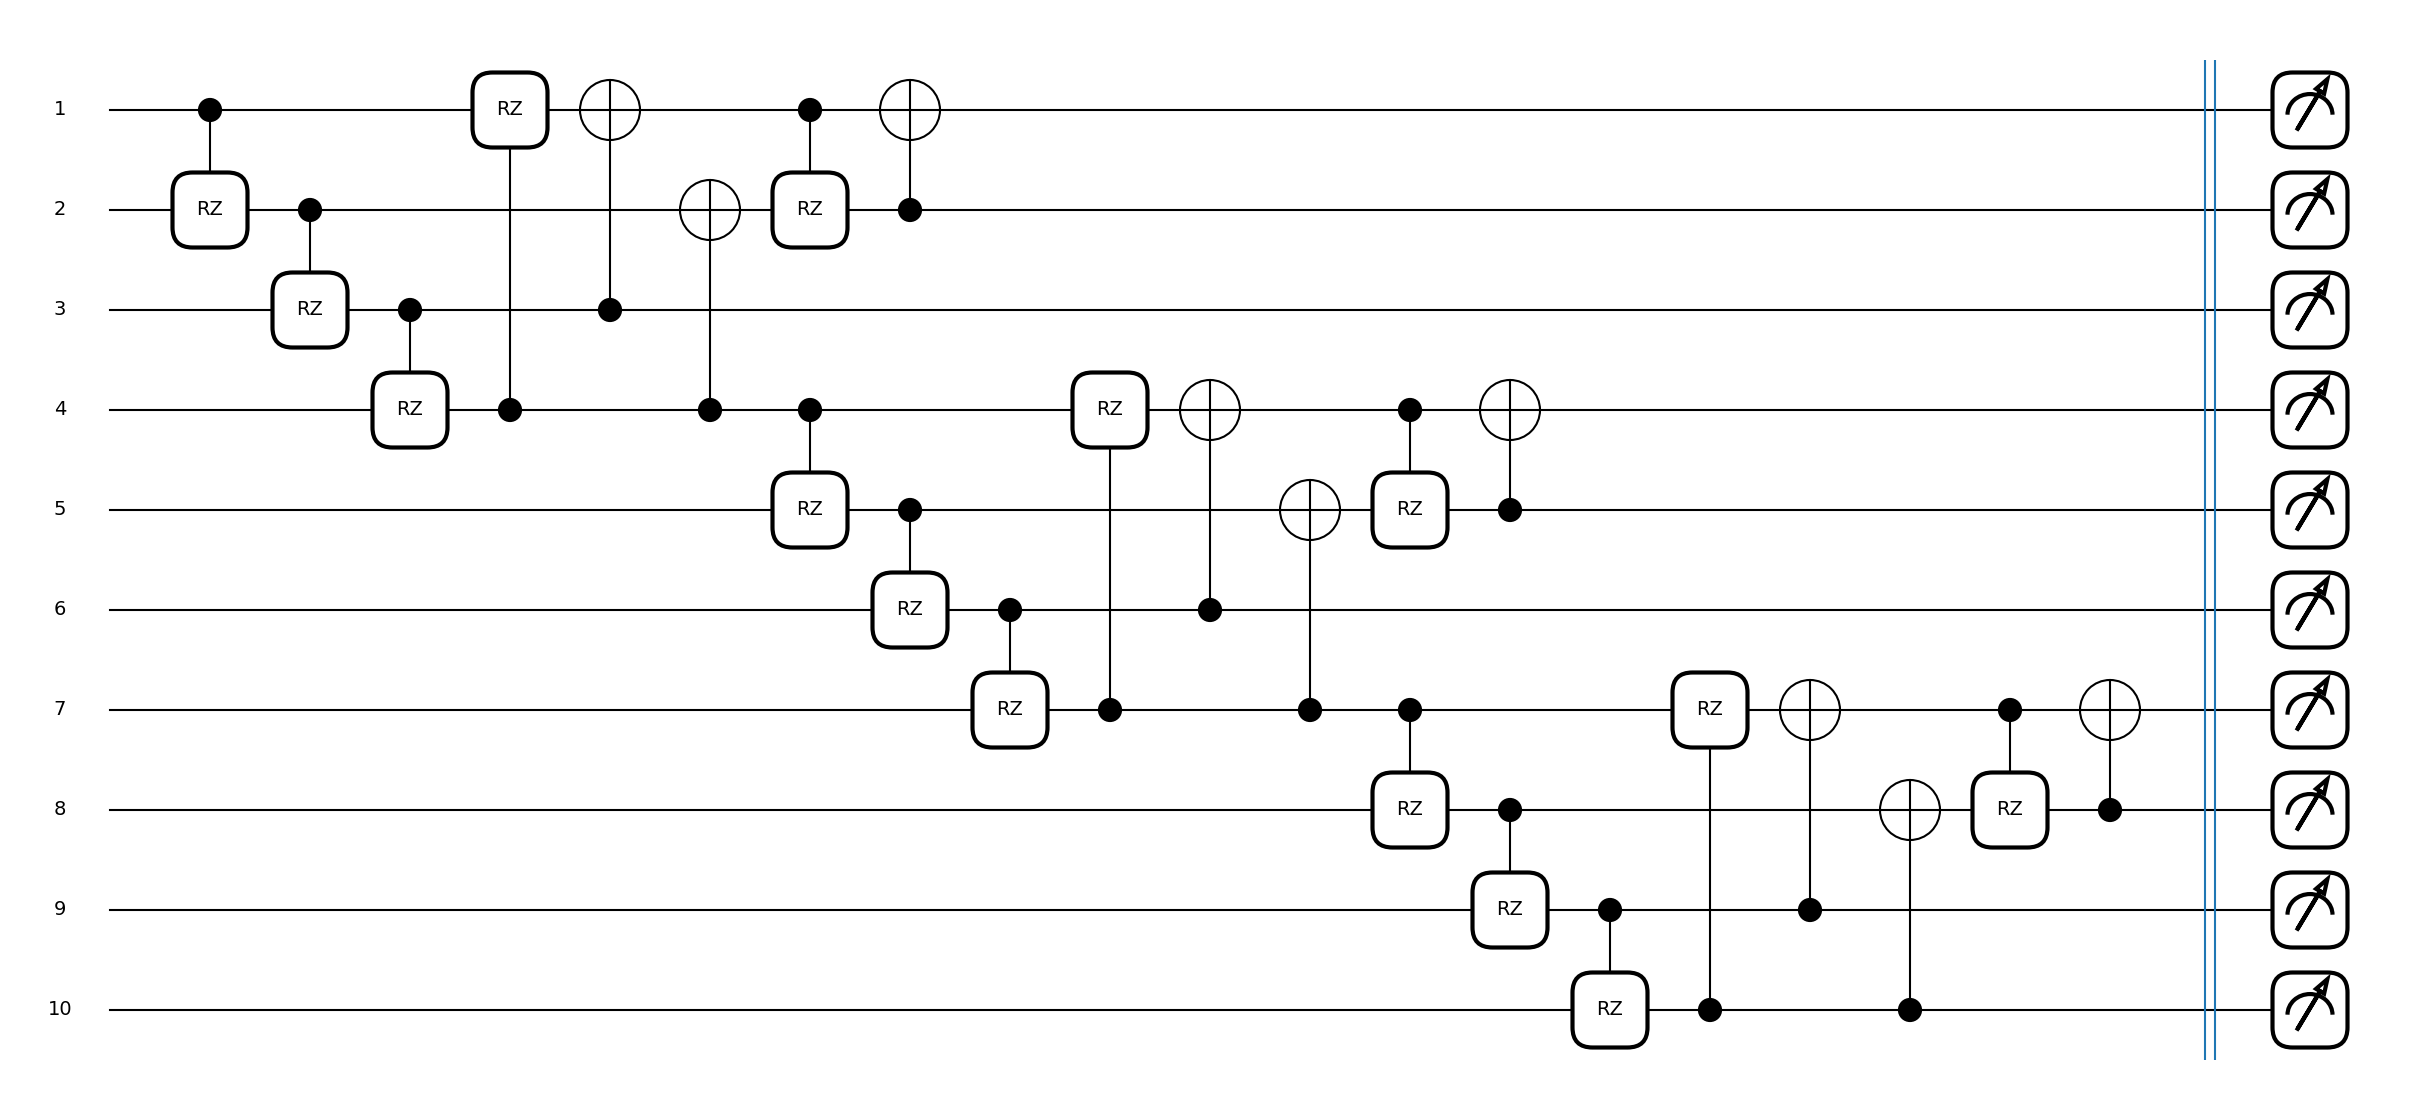

In [65]:
circuit = get_circuit(hierq)
draw_circuit(circuit)

## Masking

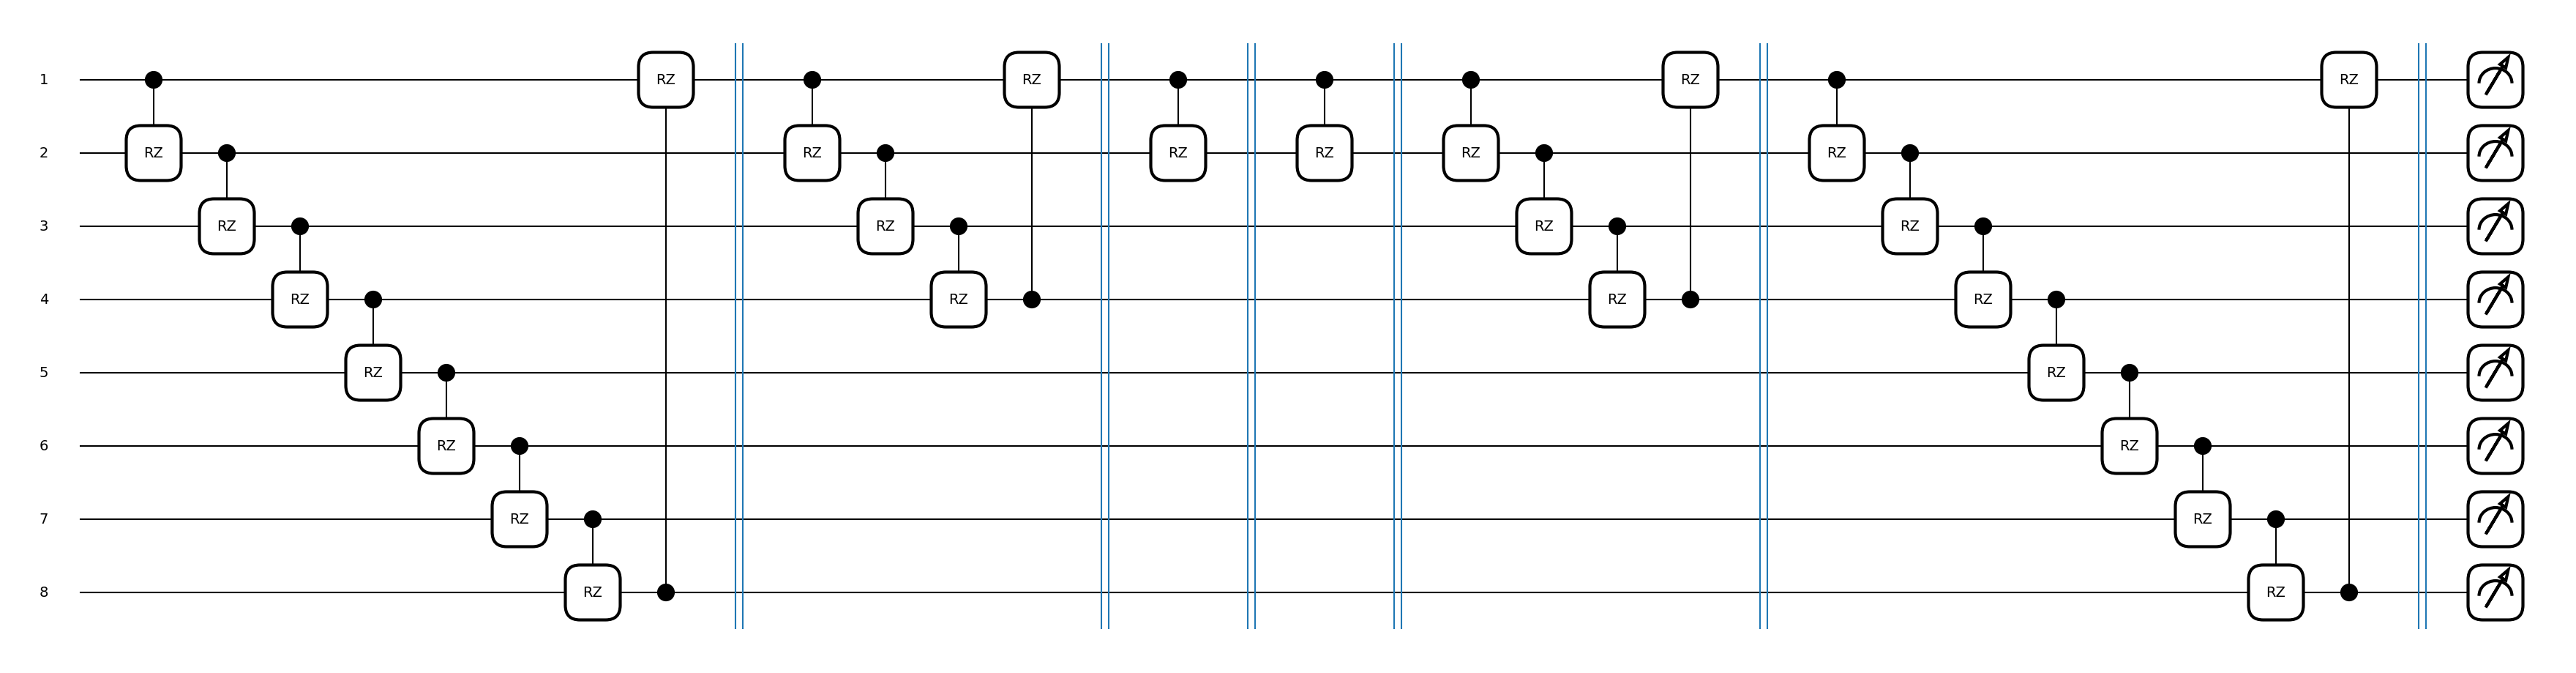

In [66]:
hierq = Qinit(8) + (Qcycle(1, 1, 0, mapping=u2) + Qmask("right"))*3 + (Qunmask("previous") + Qcycle(1, 1, 0, mapping=u2))*3
circuit = get_circuit(hierq)
draw_circuit(circuit)

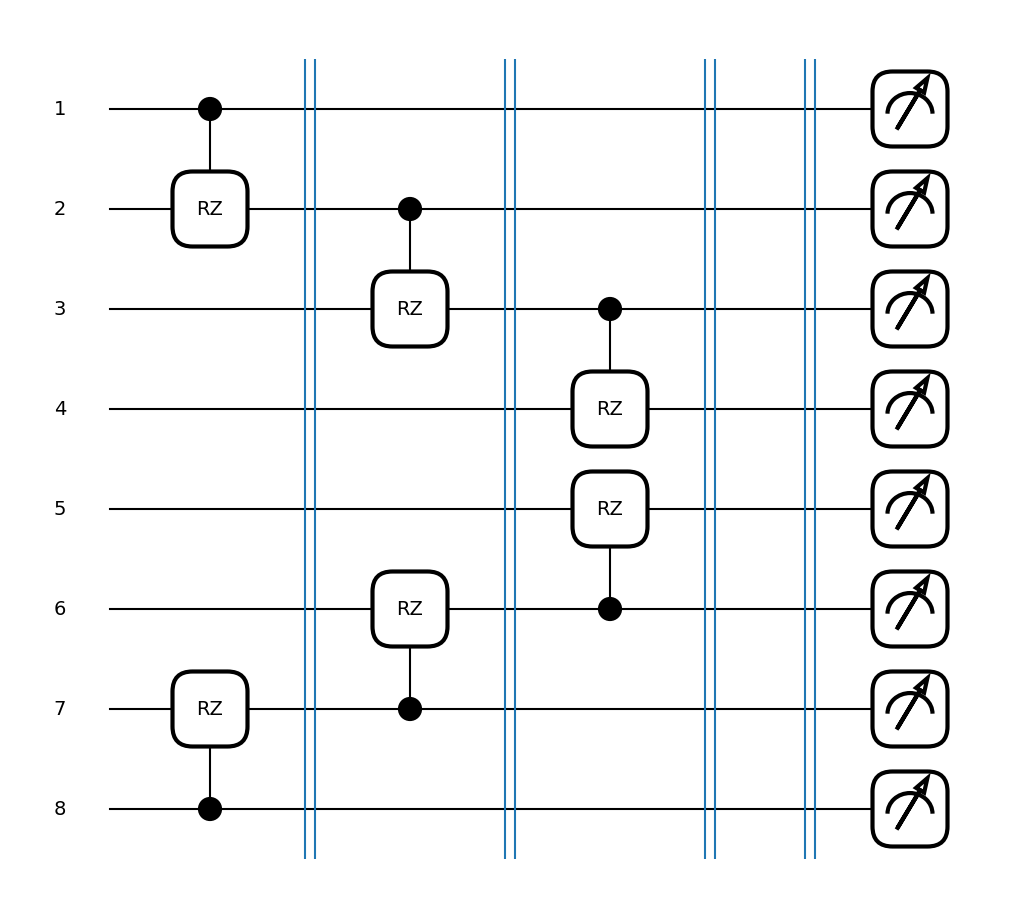

In [67]:
hierq = Qinit(8) + Qmask("1**1", connection_type="nearest_tower", mapping=u2)*4
circuit = get_circuit(hierq)
draw_circuit(circuit)

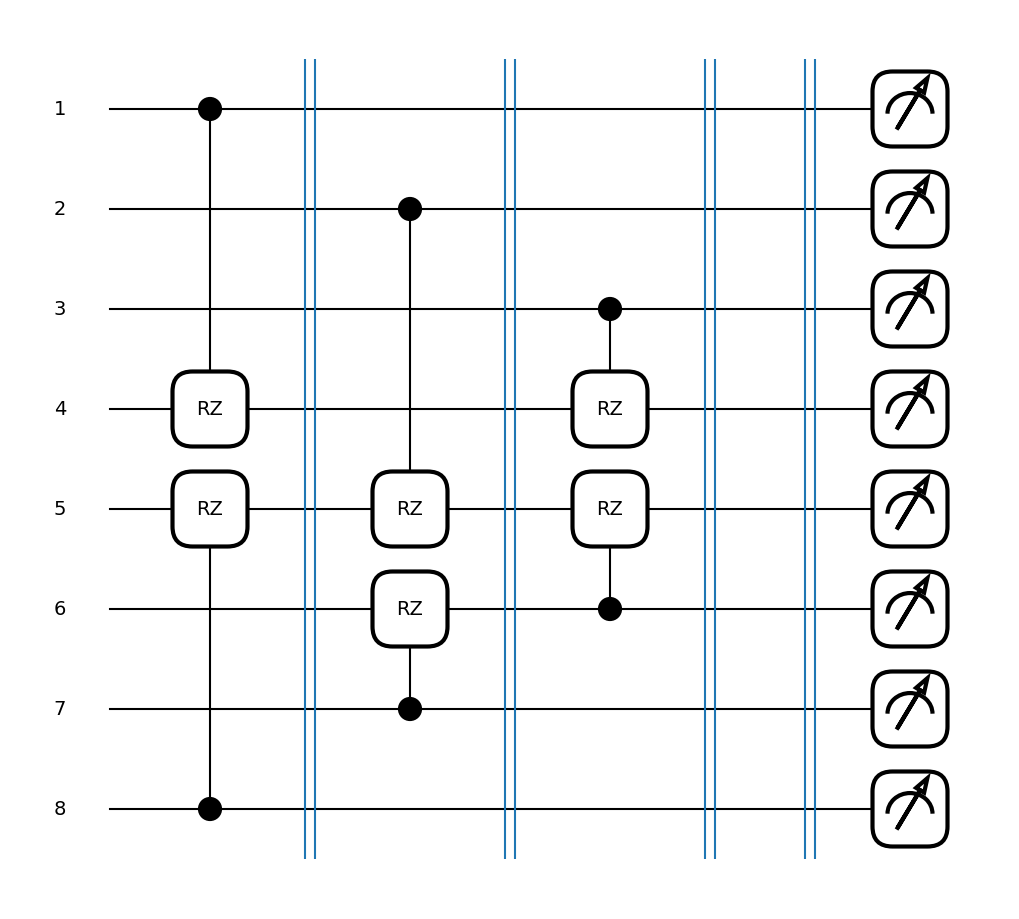

In [68]:
hierq = Qinit(8) + Qmask("1**1", stride=2, connection_type="cycle", mapping=u2)*4
circuit = get_circuit(hierq)
draw_circuit(circuit)

## Specifying unitaries

In [69]:
if backend == "qiskit":
    from qiskit.circuit import QuantumRegister
    def anz1(bits, symbols=None, circuit=None):
        
        # Assume bits are strings and in the correct QASM format
        q0, q1 = QuantumRegister(1, bits[0]), QuantumRegister(1, bits[1])
        circuit.crz(symbols[0], q0, q1)
        circuit.x(q0)
        circuit.crx(symbols[1], q0, q1)

        return circuit

    def anz2(bits, symbols=None, circuit=None):
        # Assume bits are strings and in the correct QASM format
        q0, q1 = QuantumRegister(1, bits[0]), QuantumRegister(1, bits[1])
        circuit.rz(symbols[0], q1)
        circuit.cnot(q1, q0)
        circuit.rz(symbols[1], q0)
        circuit.ry(symbols[2], q1)
        circuit.cnot(q0, q1)
        circuit.ry(symbols[3], q1)
        circuit.cnot(q1, q0)
        circuit.rz(symbols[1], q0)
        return circuit

elif backend == "cirq":
    import cirq
    # Masking circuit
    def anz1(bits, symbols=None, circuit=None):
        q0, q1 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1])
        circuit += cirq.rz(symbols[0]).on(q1).controlled_by(q0)
        circuit += cirq.X(q0)
        circuit += cirq.rx(symbols[1]).on(q1).controlled_by(q0)

        return circuit

    # Cycle circuit
    def anz2(bits, symbols=None, circuit=None):
        q0, q1 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1])
        circuit += cirq.rz(symbols[0]).on(q1)
        circuit += cirq.CNOT(q1, q0)
        circuit += cirq.rz(symbols[1]).on(q0)
        circuit += cirq.ry(symbols[2]).on(q1)
        circuit += cirq.CNOT(q0, q1)
        circuit += cirq.ry(symbols[3]).on(q1)
        circuit += cirq.CNOT(q1, q0)
        circuit += cirq.rz(symbols[4]).on(q0)
        return circuit

elif backend == "pennylane":
    # Masking circuit
    def anz1(bits, symbols=None):
        qml.CRZ(symbols[0], wires=[bits[0], bits[1]])
        qml.PauliX(wires=bits[0])
        qml.CRX(symbols[1], wires=[bits[0], bits[1]])

    # Cycle circuit
    def anz2(bits, symbols=None):
        qml.RZ(symbols[0], wires=bits[1])
        qml.CNOT(wires=[bits[1], bits[0]])
        qml.RZ(symbols[1], wires=bits[0])
        qml.RY(symbols[2], wires=bits[1])
        qml.CNOT(wires=[bits[0], bits[1]])
        qml.RY(symbols[3], wires=bits[1])
        qml.CNOT(wires=[bits[1], bits[0]])
        qml.RZ(symbols[4], wires=bits[0])


u = Qunitary(anz2, 5, 2)
v = Qunitary(anz1, 2, 2)

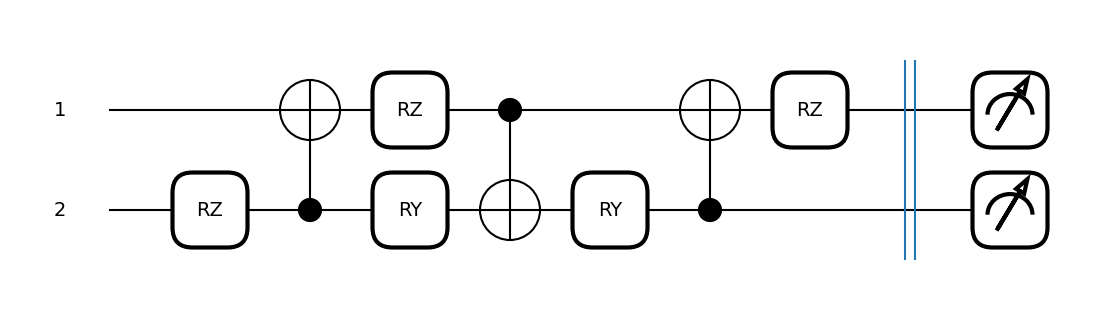

In [70]:
ansatz_1 = Qinit(2) + Qcycle(mapping=u)
circuit = get_circuit(ansatz_1)
draw_circuit(circuit)

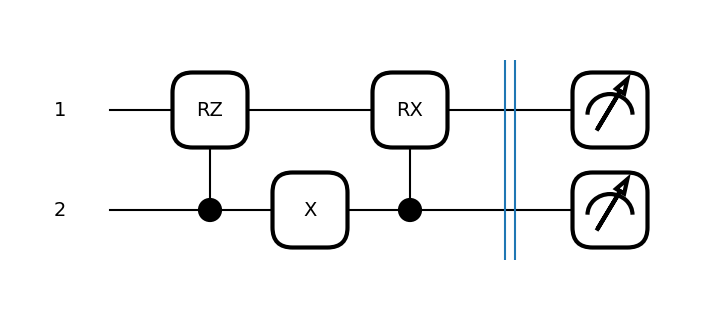

In [71]:
ansatz_2 = Qinit(2) + Qmask("right", mapping=v)
circuit = get_circuit(ansatz_2)
draw_circuit(circuit)

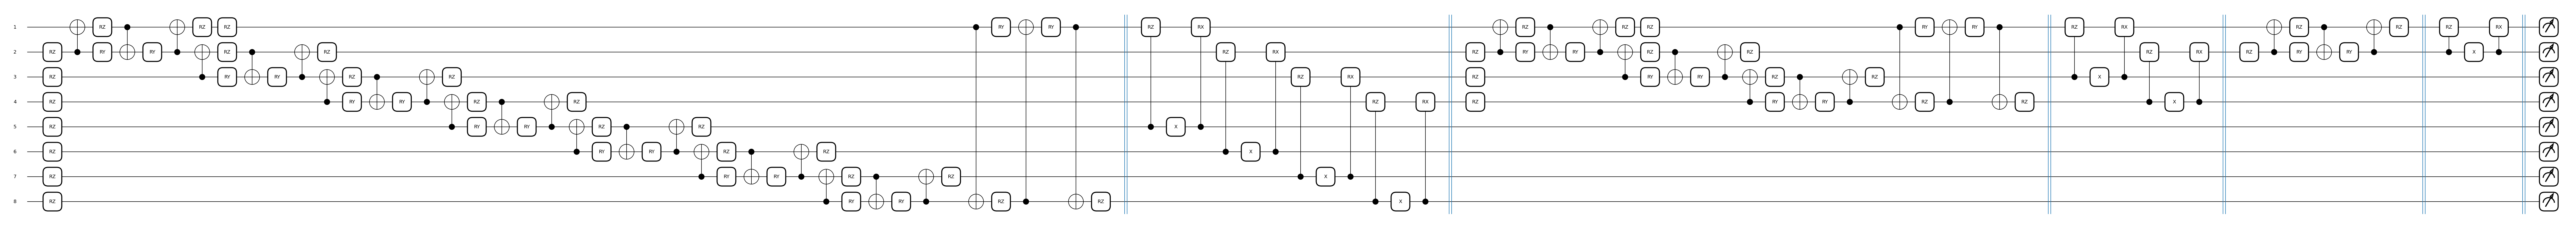

In [72]:
hierq = Qinit(8) + (Qcycle(1, mapping=u) + Qmask(pattern="right", mapping=v)) * 3
circuit = get_circuit(hierq)
draw_circuit(circuit)